# 0. Librerías y funciones

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from unidecode import unidecode
import re
import math

from scipy.stats import median_abs_deviation
from statistics import median
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, median_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.inspection import PartialDependenceDisplay

# default figure size: [6.4, 4.8]
plt.style.use('default') # estilo de los gráficos
pd.set_option('display.max_columns', 200) # para que al mostrar la tabla se vean todas las columnas (hasta 200)
pd.options.mode.copy_on_write = True
np.set_printoptions(precision=5, suppress=True) # 5 decimales máximo

# 1. Carga de los datos

## 1.1. Carga del dataset de Idealista

In [30]:
df = pd.read_csv('datasets/inmuebles_alquiler_idealista_052024.csv', index_col = 0) # 24-05-2024

In [31]:
# URL duplicadas
df.sort_values('Hora_actual', inplace = True) # ordena por hora de forma ascendente
df.drop_duplicates(subset = 'URL_ingresadas', keep = 'last', inplace  = True) # me quedo con la instancia más reciente de URL duplicada
df.sort_index(inplace = True) # vuelve a la ordenación por índice original (aleatoria)

In [32]:
# Elimino las columnas redundantes o irrelevantes
df.drop(["Características_destacadas", "Ref", "Profesional", "Contacto_URL", "Imagen", "Página_URL", "Hora_actual"], axis = 1, inplace = True) #"Certificado_energetico"
df.rename({'Certificado_energetico' : 'Certificado_energético'}, axis = 1, inplace = True)

In [33]:
df.shape

(20643, 10)

In [34]:
df.head(5)

,URL_ingresadas,Titulo,Precio,Ubicación,Comentario_del_anunciante,Características_básicas,Edificio,Equipamiento,Certificado_energético,Com_autónoma
0,https://www.idealista.com/inmueble/97753710/,"Alquiler de Piso en calle Rodrigo Manrique, 2",500 €/mes,"Calle Rodrigo Manrique, 2Distrito Puerta de Mu...",A partir de Junio. Dispone de sofá-cama. Piso ...,68 m² construidos 1 habitación 1 baño Balcó...,Planta 2ª exteriorCon ascensor,NaN,En trámite,Castilla-La Mancha
1,https://www.idealista.com/inmueble/104965918/,Alquiler de Piso en El Consul - El Romeral,1.400 €/mes,Barrio El Consul - El RomeralDistrito Teatinos...,¡Espectacular piso para CHICAS ESTUDIANTES!Alq...,"100 m² construidos, 90 m² útiles 3 habitacion...",Planta 1ª exteriorCon ascensor,Aire acondicionado,Consumo: Emisiones: Ver etiqueta de ...,Andalucía
2,https://www.idealista.com/inmueble/104930431/,"Alquiler de Ático en calle de Hernán Cortés, 30",1.250 €/mes,"Calle de Hernán Cortés, 30Barrio Doctor Cerrad...","En el corazón de Zaragoza, junto a la emblemát...",80 m² construidos 2 habitaciones 2 baños Ba...,Planta 4ª exteriorCon ascensor,NaN,No indicado,Aragón
3,https://www.idealista.com/inmueble/98741615/,"Alquiler de Piso en calle Granada, 4",700 €/mes,"Calle Granada, 4MiñoMiño - Betanzos, A Coruña","Alquiler Piso temporal por maximo 11 meses, de...","80 m² construidos, 75 m² útiles 3 habitacione...",Planta 2ª exteriorSin ascensor,NaN,En trámite,Galicia
4,https://www.idealista.com/inmueble/104965258/,"Alquiler de Piso en calle Tarongers, 4",1.400 €/mes,"Calle Tarongers, 4Distrito Colònia de Sant Per...",Bonita vivienda para pasar unas inmejorables v...,"70 m² construidos, 68 m² útiles 2 habitacione...",Bajo exteriorSin ascensor,Aire acondicionado Piscina Zonas verdes,Consumo: Emisiones: Ver etiqueta de ...,Islas Baleares


## 1.2. Importación de otros conjuntos de datos

### 1.2.1. Provincias de España

https://www.ine.es/daco/daco42/codmun/cod_ccaa_provincia.htm

In [35]:
df_provincias = pd.read_csv("datasets/provincias24.csv")

# Algunas provincias en este dataset no están en el mismo formato que en los datos
df_provincias.Provincia = df_provincias.Provincia.str.replace('Balears, Illes', 'Balears (Illes)')
df_provincias.Provincia = df_provincias.Provincia.str.replace('Palmas, Las', 'Las Palmas')
df_provincias.Provincia = df_provincias.Provincia.str.replace('Alicante/Alacant', 'Alicante')
df_provincias.Provincia = df_provincias.Provincia.str.replace('Castellón/Castelló', 'Castellón')
df_provincias.Provincia = df_provincias.Provincia.str.replace('Valencia/València', 'València')
df_provincias.Provincia = df_provincias.Provincia.str.replace('Coruña, A', 'A Coruña')
df_provincias.Provincia = df_provincias.Provincia.str.replace('Araba/Álava', 'Álava')
df_provincias.Provincia = df_provincias.Provincia.str.replace('Gipuzkoa', 'Guipúzcoa')
df_provincias.Provincia = df_provincias.Provincia.str.replace('Bizkaia', 'Vizcaya')
df_provincias.Provincia = df_provincias.Provincia.str.replace('Rioja, La', 'La Rioja')

df_provincias.head()

,CODAUTO,Comunidad Autónoma,CPRO,Provincia
0,1,Andalucía,4,Almería
1,1,Andalucía,11,Cádiz
2,1,Andalucía,14,Córdoba
3,1,Andalucía,18,Granada
4,1,Andalucía,21,Huelva


### 1.2.2. Municipios de España

https://www.ine.es/daco/daco42/codmun/diccionario24.xlsx

In [36]:
df_solo_muni = pd.read_excel("datasets/diccionario24.xlsx", skiprows = 1)
df_solo_muni.rename({'NOMBRE' : 'Municipio'}, axis = 1, inplace = True)
df_solo_muni.head()

,CODAUTO,CPRO,CMUN,DC,Municipio
0,16,1,51,3,Agurain/Salvatierra
1,16,1,1,4,Alegría-Dulantzi
2,16,1,2,9,Amurrio
3,16,1,49,3,Añana
4,16,1,3,5,Aramaio


In [37]:
# Junto el dataset de provincias con el de municipios con el CPRO
df_municipios = pd.merge(df_provincias, df_solo_muni.drop('CODAUTO', axis = 1), on = "CPRO", how = "inner")
df_municipios
df_municipios.head()

,CODAUTO,Comunidad Autónoma,CPRO,Provincia,CMUN,DC,Municipio
0,1,Andalucía,4,Almería,1,0,Abla
1,1,Andalucía,4,Almería,2,5,Abrucena
2,1,Andalucía,4,Almería,3,1,Adra
3,1,Andalucía,4,Almería,4,6,Albanchez
4,1,Andalucía,4,Almería,5,9,Alboloduy


In [38]:
print('Hay', df_municipios.CODAUTO.max(), 'comunidades autónomas,\nhay', 
      df_municipios.CPRO.max(), 'provincias y\nhay',
df_municipios.shape[0], 'municipios en España.')

Hay 19 comunidades autónomas,
hay 52 provincias y
hay 8132 municipios en España.


Se tienen que cambiar los municipios con nombre 'Ejido, El' a 'El Ejido'.

In [39]:
def modificar_nombres_municipios(text):
    
    # Regular expression pattern to capture the comma, any whitespace, and any characters following it
    pre, post = text.split(', ')
    modified_text = " ".join([post, pre])
    
    return modified_text

In [40]:
# Aplicar la función anterior a los municipios que contienen una coma
df_municipios_comas = df_municipios.loc[df_municipios['Municipio'].str.contains(',')]
df_municipios_comas['Municipio'] = df_municipios_comas['Municipio'].apply(lambda x: modificar_nombres_municipios(x))
df_municipios_comas.head()

,CODAUTO,Comunidad Autónoma,CPRO,Provincia,CMUN,DC,Municipio
38,1,Andalucía,4,Almería,902,6,El Ejido
45,1,Andalucía,4,Almería,48,6,Los Gallardos
62,1,Andalucía,4,Almería,903,2,La Mojonera
91,1,Andalucía,4,Almería,901,1,Las Tres Villas
110,1,Andalucía,11,Cádiz,8,6,Los Barrios


In [41]:
# Juntar el df con comas con los municipios que no tienen coma en df_municipios
df_municipios_sin_comas = df_municipios.loc[~df_municipios['Municipio'].str.contains(',')]
df_municipios = pd.concat([df_municipios_comas, df_municipios_sin_comas])
print(df_municipios.shape)
df_municipios.head()

(8132, 7)


,CODAUTO,Comunidad Autónoma,CPRO,Provincia,CMUN,DC,Municipio
38,1,Andalucía,4,Almería,902,6,El Ejido
45,1,Andalucía,4,Almería,48,6,Los Gallardos
62,1,Andalucía,4,Almería,903,2,La Mojonera
91,1,Andalucía,4,Almería,901,1,Las Tres Villas
110,1,Andalucía,11,Cádiz,8,6,Los Barrios


### 1.2.3. Población de los municipios

https://www.ine.es/dynt3/inebase/index.htm?padre=525

In [42]:
df_poblacion = pd.read_excel('Datasets/pobmun23.xlsx', skiprows= 1)

In [43]:
df_poblacion.head()

,CPRO,PROVINCIA,CMUN,NOMBRE,POB23,HOMBRES,MUJERES
0,2,Albacete,1,Abengibre,760,369,391
1,2,Albacete,2,Alatoz,491,268,223
2,2,Albacete,3,Albacete,173206,84585,88621
3,2,Albacete,4,Albatana,655,332,323
4,2,Albacete,5,Alborea,666,350,316


# 2. Extracción de nuevas variables estructuradas

## 2.1. Precio

In [44]:
df['Precio'] = pd.to_numeric(df['Precio'].apply(lambda x: x.replace('.', '').replace(' €', '').replace('/mes', '').replace(',', '.')), downcast='float')
print('NA:', df['Precio'].isna().sum())
df.Precio.describe()

NA: 0


count     20643.000000
mean       1771.933716
std        2884.842529
min         100.000000
25%         750.000000
50%        1100.000000
75%        1800.000000
max      120000.000000
Name: Precio, dtype: float64

## 2.2. Obtener la ubicación

### Provincia

In [45]:
# La Provincia siempre es/son la/s palabra/s después de la coma hasta el final del texto.
df['Provincia'] = df['Ubicación'].apply(lambda x: x.split(', ')[-1])

In [46]:
print('NA: ',df.Provincia.isna().sum()) # 0
df.Provincia.value_counts().head()

NA:  0


Provincia
Madrid             1757
Murcia             1534
Barcelona          1425
Balears (Illes)    1404
Asturias           1189
Name: count, dtype: int64

### Comarca

In [47]:
# Hacer que haya espacios antes de cada letra mayúscula para separar palabras.

def insert_spaces(text):
    # Expressión regular de una palabra
    word_pattern = r"\S+"

    # Separa el texto en palabras
    words = re.findall(word_pattern, text)

    # Modifica cada palabra para añadir un espacio antes de cada letra mayúscula (excepto la primera)
    modified_words = []
    for word in words:
        modified_word = ""
        for i in range(len(word)):
            if i > 0 and word[i].isupper() and (word[i - 1].islower() or word[i - 1].isnumeric()):
                modified_word += " "
            modified_word += word[i]
        modified_words.append(modified_word)

    # Join the modified words back into a string
    modified_text = " ".join(modified_words)

    return modified_text #result_text

# Eliminar la provincia (detrás de la coma) y separar las palabras por espacios
df['Ubicación_clean'] = df['Ubicación'].apply(lambda x: insert_spaces(" ".join(x.split(",")[:-1])))

In [48]:
# Comarcas de España (zonas) según Idealista
comarcas = {
    'Madrid' : ['Zona norte', 'Zona sureste', 'Zona sur', 'Zona suroeste', 'Zona noroeste', 'Madrid capital', 'Corredor del Henares'],
    'Almería' : ['Los Vélez', 'Bajo Almanzora', 'Valle de Almanzora', 'Filabres', 'Campo de Tabernas', 'Levante', 'Parque Natural Cabo de Gata - Níjar', 'Poniente', 'Alpujarras', 'Área de Almería'],
    'Cádiz' : ['Costa noroeste', 'Campiña de Jerez', 'Sierra de Cádiz', 'Campo de Gibraltar', 'La Janda', 'Bahía de Cádiz'],
    'Córdoba' : ['Los Pedroches', 'Alto Guadalquivir', 'Alto Guadiato', 'Vega del Guadalquivir', 'Córdoba', 'Campiña sur-Campiña este', 'La Subbética'],
    'Granada' : ['Los Montes', 'Poniente Granadino', 'Valle de Lecrín', 'Costa Tropical', 'Alpujarra Granadina', 'Área de Granada', 'Área de Guadix', 'Área de Baza', 'Área de Huéscar'], 
    'Huelva' : ['Sierra', 'El Andévalo', 'El Condado', 'La Costa'],   
    'Jaén' : ['La Campiña', 'Sierra sur', 'Sierra Mágina', 'Alto Guadalquivir', 'La Loma y las Villas', 'Comarca norte - El Condado', 'Sierra de Segura', 'Jaén'],
    'Málaga' : ['Costa del Sol Oriental - Axarquía', 'Comarca de Málaga', 'Costa del Sol Occidental-Área de Benalmádena-Costa', 'Serranía de Ronda', 'Valle de Guadalhorce', 'Costa del Sol Occidental-Área de Marbella', 'Costa del Sol Occidental - Área de Estepona', 'Área de Antequera'],
    'Sevilla' : ['Sierra norte', 'La Vega', 'Aljarafe', 'La Campiña', 'Sevilla capital', 'La Marisma', 'Área Metropolitana', 'Área de Estepa'],
    'Huesca' : ['La Jacetania', 'Alto Gállego', 'Sobrarbe', 'Ribagorza', 'La Litera', 'Somontano de Barbastro', 'Hoya de Huesca', 'Los Monegros', 'Cinca'],
    'Teruel' : ['Matarraña', 'Bajo Aragón', 'Maestrazgo', 'Gúdar- Javalambre', 'Albarracín', 'Jiloca', 'Cuencas Mineras- Andorra-Bajo Martín', 'Área de Teruel'],
    'Zaragoza' : ['La Muela-Valdejalón', 'Cinco Villas - Jacetania', 'Hoya de Huesca', 'Monegros', 'Bajo Cinca', 'Caspe', 'Ribera Baja del Ebro', 'Campo de Belchite', 'Ribera Alta del Ebro', 'Campo de Borja', 'Tarazona-El Moncayo', 'Campo de Cariñena', 'Campo de Daroca', 'Comunidad de Calatayud', 'Área de Zaragoza', 'Aranda'],
    'Cantabria' : ['Liébana', 'Campoo-Los Valles', 'Saja - Nansa', 'Costa Occidental', 'Besaya', 'Valles Pasiegos', 'Trasmiera', 'Asón-Agüera', 'Costa Orienta', 'Área de Santander', 'Área de San Vicente de la Barquera'], 
    'Ávila' : ['Arévalo', 'Burgohondo - Cebreros - El Tiemblo', 'Valle del Tiétar', 'Valle del Tormes', 'Área de Ávila'],
    'Burgos' : ['Merindades', 'Odra-Paramos', 'La Bureba', 'Ebro', 'Treviño', 'Montes de Oca', 'Arlanza', 'Demanda', 'Ribera', 'Área de Burgos'], 
    'León' : ['Las Montañas', 'Babia- Laciana- Omaña', 'Bierzo- Ancares', 'Maragatería- Cabrera', 'El Páramo', 'Tierra de Campos', 'Tierras de León'], 
    'Palencia' : ['Montaña Palentina', 'Camino de Santiago', 'Tierra de Campos - Cerrato'],
    'Salamanca' : ['Vitigudino', 'Peñaranda', 'Campo Charro', 'Béjar', 'Ciudad Rodrigo', 'Área Metropolitana'], 
    'Segovia' : ['Área de Riaza', 'Área de Sepúlveda - Cantalejo', 'Área de Cuéllar', 'Área de Santa María Real de Nieva', 'Área de Segovia'],
    'Soria' : ['Pinares y Tierras Altas', 'Almazán', 'Burgo de Osma', 'Área de Soria'],
    'Valladolid' : ['Tierra de Campos', 'Tierra de Pinares', 'Tierra de Medina', 'Tordesillas', 'Área Metropolitana Valladolid'],
    'Zamora' : ['Sanabria', 'Benavente', 'Tierra de Campos', 'Alfoz de Toro', 'Tierra del Vino - La Guareña', 'Aliste', 'Área de Sayago', 'Área de Zamora'],
    'Albacete' : ['La Mancha', 'La Manchuela', 'Centro', 'Corredor de Almansa', 'Campo de Hellín', 'Sierra de Alcaraz-Segura'],
    'Ciudad Real' : ['Los Montes', 'Sierra Morena', 'Calatrava', 'La Mancha', 'Alcudia', 'Montiel'],
    'Cuenca' : ['La Alcarria', 'Serranía Alta', 'Serranía Media', 'Serranía Baja', 'Manchuela', 'Mancha Alta', 'Mancha Baja'], 
    'Guadalajara' : ['Campiña', 'Sierra', 'Molina de Aragón', 'Alcarria Alta', 'Alcarria Baja'],
    'Toledo' : ['La Mancha', 'Sierra de San Vicente', 'Área de Torrijos', 'Talavera', 'La Campana de Oropesa', 'La Jara', 'Los Montes de Toledo', 'Toledo', 'La Mesa de Ocaña', 'La Sagra'],
    'Barcelona' : ['Barcelonès', 'Berguedà', 'Moianès', 'Bages', 'Anoia', 'Alt Penedès', 'Baix Llobregat Nord', 'Baix Llobregat Sud', 'Garraf', 'Maresme', 'Vallès Oriental', 'Vallès Occidental', 'Osona', 'Área de Barcelona'], 
    'Girona' : ['La Cerdanya', 'Ripollès', 'La Garrotxa', 'Alt Empordà', "Pla de l'Estany", 'Gironès', 'La Selva', 'Baix Empordà'], 
    'Lleida' : ["Val d'Aran", 'Pallars Sobirà', 'Alta Ribagorça', 'Pallars Jussà', 'Alt Urgell', 'Cerdanya', 'Solsonès', 'Segarra', 'Noguera', "Pla d'Urgell", 'Urgell', 'Garrigues', 'Segrià', 'Área de Balaguer'],
    'Tarragona' : ['Conca de Barberà', 'Alt Camp', 'Baix Penedès', 'Tarragonès', 'Baix Camp', 'Priorat', "Ribera d'Ebre", 'Terra Alta', 'Baix Ebre', 'Montsià'],
    'Navarra' : ['Área de Pamplona', 'Olite', 'Área de Sangüesa', 'Área de Esteribar', 'Área de Estella y Urbasa', 'Área de Tafalla', 'Área de Puente la Reina', 'Área de Tudela', 'Área de Peralta', 'Norte'],
    'Alicante' : ['Marina Alta', 'Marina Baixa', 'Comtat', "L'Alcoià", "L'Alacantí", 'Vinalopó Mitjà', 'Alt Vinalopó', 'Baix Vinalopó', 'Baix Segura'],
    'Castellón' : ['Baix Maestrat', 'Els Ports', 'Alt Maestrat', 'Plana Alta', "L'Alcalaten", 'Plana Baixa', 'Alto Mijares', 'Alto Palancia'],
    'València' : ['El Rincón de Ademuz', 'Los Serranos', 'El Camp de Tùria', 'Camp de Morvedre', "L'Horta Nord", "L'Horta Sud", 'Valencia', 'Hoya de Buñol', "La Plana d'Utiel", 'El Valle de Ayora', 'El Canal de Navarrés', 'Ribera Alta', 'Ribera Baixa', 'Safor', 'La Costera', "La Vall d'Albaida"],
    'Badajoz' : ['Badajoz-Alburquerque', 'Don Benito-Siberia-Serena', 'Tierra de Barros - Tierras de Zafra', 'Campiña sur', 'Tentudía', 'Jerez de los Caballeros', 'Llanos de Olivenza', 'Área de Mérida'],
    'Cáceres' : ['Sierra de Gata', 'Las Hurdes-Ambroz', 'Valle del Alagón', 'El Jerte', 'La Vera', 'Campo Arañuelo', 'Villuercas - Ibores - Jara', 'Trujillo', 'Alcántara', 'Área de Cáceres'],
    'A Coruña' : ['Área de A Coruña', 'Ortegal', 'Eume', 'Miño - Betanzos', 'Terra de Melide', 'Arzúa', 'Ordes', 'Bergantiños', 'Terra de Soneira', 'Xallas', 'A Barcala', 'Santiago', 'O Sar', 'Barbanza', 'Noia', 'Muros', 'Fisterra', 'Área de Ferrol'], 
    'Lugo' : ['A Mariña', 'Terra Chá', 'Meira', 'A Fonsagrada', 'Ancares', 'Sarria', 'Ulloa', 'Chantada', 'Lemos', 'Quiroga', 'Área de Lugo'],
    'Ourense' : ['Carballiño', 'Ribeiro', 'Terra de Celanova', 'Allariz- Maceda', 'Terra de Caldelas- Trive', 'Valdeorras', 'Viana- Verín', 'Área de Ourense', 'Limia'],  
    'Pontevedra' : ['Salnés', 'Morrazo', 'Condado - Paradanta', 'Baixo Miño', 'Área de Deza', 'Área de Terra Montes', 'Área de Caldas', 'Área de Pontevedra', 'Área de Vigo'],
    'Balears (Illes)' : ['Mallorca', 'Menorca', 'Ibiza', 'Formentera'],
    'Las Palmas' : ['Gran Canaria', 'Lanzarote', 'Fuerteventura'],
    'Santa Cruz de Tenerife' : ['Tenerife', 'La Gomera', 'La Palma', 'El Hierro'],
    'La Rioja' : ['Rioja Alta', 'Los Cameros', 'Rioja Baja', 'Área de Logroño'],
    'Álava' : ['Ayala', 'Zuya', 'Añana', 'Vitoria-Gasteiz', 'Salvatierra', 'Campezo- Montaña Alavesa', 'Laguardia-Rioja Alavesa'],
    'Guipúzcoa' : ['Bajo Bidasoa', 'Donostialdea', 'Urola Kosta', 'Bajo Deba', 'Alto Deba', 'Goierri', 'Tolosaldea'],
    'Vizcaya' : ['Encartaciones', 'Arratia-Nervión', 'Gran Bilbao', 'Uribe-Butroe', 'Busturialdea', 'Lea-Artibai', 'Duranguesado'],
    'Asturias' : ['Eo-Navia', 'Narcea', 'Caudal', 'Oriente', 'Área de Oviedo', 'Área de Gijón', 'Área de Avilés', 'Nalón'],
    'Murcia' : ['Altiplano-Oriental', 'Vega Alta', 'Noroeste', 'Río Mula', 'Vega Media', 'Valle de Ricote', 'La Manga del Mar Menor', 'Campo de Cartagena', 'Bajo Guadalentín', 'Alto Guadalentín', 'Área de Murcia', 'Mar Menor'],
    'Ceuta' : ['Comarca de Ceuta'],
    'Melilla' : ['Comarca de Melilla']
}

In [49]:
def encontrar_comarca(ubicacion, provincia):
    
    if provincia in comarcas:
        comarcas_prov = comarcas[provincia]
        for comarca in comarcas_prov:
            if(comarca in ubicacion):
                return (comarca)      
          

In [50]:
# Obtener la comarca (o zona) del apartamento dentro de la provincia dada
df['Comarca'] = df.apply(lambda row: encontrar_comarca(row['Ubicación_clean'], row['Provincia']), axis = 1)

In [51]:
def eliminar_comarca(ubicacion, comarca):

    #return(ubicacion.rsplit(comarca, maxsplit = 1)[0])

    ubi_split = ubicacion.rsplit(comarca, maxsplit = 1)

    #ubi_split = ubicacion.split(comarca)
    if len(ubi_split) > 2:
        return (ubi_split[0] + str(comarca))
    if len(ubi_split) == 0:
        return ''
    return (ubi_split[0].rstrip()) # .rstrip() para eliminar el espacio al final


In [52]:
# Eliminar comarca de la ubicación (sustituir por espacio en blanco)
df['Ubicación_clean'] = df.apply(lambda row: eliminar_comarca(row['Ubicación_clean'], row['Comarca']), axis = 1)

In [53]:
print('NA: ',df.Comarca.isna().sum()) # 0
df.Comarca.value_counts().head()

NA:  0


Comarca
Madrid capital        1458
Área de Barcelona     1098
Mallorca              1072
Gran Canaria           869
Área Metropolitana     842
Name: count, dtype: int64

### Municipio

In [54]:
# Modificación de municipios del dataset que no están en df_municipios en el mismo formato
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Valle de Bardají', 'Valle de Bardagi')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Sabiñánigo', 'Sabiñanigo')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Villava/Atarrabia', 'Villava')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Buenavista del Norte', 'Buenavista del norte')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Arrasate/Mondragón', 'Arrasate o Mondragon')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Maria de la Salut', 'Maria de la Salud')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Cangas del Narcea', 'Cangas de Narcea')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Vilafranca', 'Villafranca') # de Bonany
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('El Sauzal', 'Sauzal')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('O Pereiro de Aguiar', 'Pereiro de Aguiar')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Valle de Egüés/Eguesibar', 'Egüés')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace('Iruña Oka/Iruña de Oca', 'Iruña de Oca')
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("L' Espluga de Francolí", "L'Espluga de Francoli")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Donostia/San Sebastián", "Donostia-San Sebastián")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Alacant/Alicante", "Alicante")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Orpesa/Oropesa del Mar", "Oropesa del Mar")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Medina Sidonia", "Medina-Sidonia")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Sangüesa/Zangoza", "Sangüesa")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Banyalbufar", "Bañalbufar")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Valle de Yerri/Deierri", "Yerri")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Lloret de Vistalegre", "Lloret de Vista Alegre")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Elx/Elche", "Elche / Elx")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Benicàssim/Benicasim", "Benicasim/Benicàssim")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Santa Eulària des Riu", "Santa Eulalia del Río")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Alboraia/Alboraya", "Alboraya")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("l' Eliana", "L'Eliana")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Alcoi/Alcoy", "Alcoy / Alcoi")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Borriana/Burriana", "Burriana")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("l' Alcora", "Alcora")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Sagunto/Sagunt", "Sagunto")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Xàbia/Jávea", "Jávea/Xàbia")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Nàquera/Náquera", "Náquera")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Sagunt/Sagunto", "Sagunto")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("El Perellonet", "València")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Calonge i Sant Antoni", "Calonge")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Noáin (Valle de Elorz)/Noain (Elortzibar)", "Noáin (Valle de Elorz)")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Sant Joan d'Alacant", "San Juan de Alicante")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Abanto y Ciérvana-Abanto Zierbena", "Abanto y Ciérvana")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Barañáin/Barañain", "Barañain")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("A Laracha", "Laracha")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("A Illa de Arousa", "Illa de Arousa")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Juslapeña/Txulapain", "Juslapeña")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("la/Villajoyosa Vila Joiosa", "Villajoyosa")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Ayala/Aiara", "Ayala")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Estella-Lizarra", "Estella")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("A Pobra do Caramiñal", "Puebla del Caramiñal")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("L' Hospitalet de Llobregat", "Hospitalet de Llobregat")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Alfarb", "Alfarp")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Zuia", "Zuya")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Las Casas", "Ciudad Real")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("l' Olleria", "L'Olleria")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Ansoáin/Antsoain", "Ansoain")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("el/Pinoso Pinós", "Pinoso")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("La Puebla de Alfindén", "Puebla de Alfindén")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("l' Alfàs del Pi", "Alfaz del Pi")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Chilches/Xilxes", "Chilches")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Xixona/Jijona", "Jijona")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Peníscola/Peñíscola", "Peñíscola")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("el/Benitachell Poble Nou de Benitatxell", "Benitachell")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Laudio/Llodio", "Llodio")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Iza/Itza", "Iza")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Peralta/Azkoien", "Peralta")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Berrioplano/Berriobeiti", "Berrioplano")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Vielha e Mijaran", "Vielha")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Valdegovía/Gaubea", "Valdegovia")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Benalup-Casas Viejas", "Benalup")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Cendea de Olza/Oltza Zendea", "Cendea de Olza")
df_municipios['Municipio'] = df_municipios['Municipio'].str.replace("Burlada/Burlata", "Burlada")

# Modificación de titulos que no muestra exacatament el nombre del municipio de df_municipios
df['Titulo'] = df['Titulo'].str.replace('San Ildefonso o la Granja', 'Real Sitio de San Ildefonso')
df['Titulo'] = df['Titulo'].str.replace('Playa de Farnals', 'la Pobla de Farnals')
df['Titulo'] = df['Titulo'].str.replace('El Grau de Castelló', 'Castelló de la Plana')
df['Titulo'] = df['Titulo'].str.replace('Ajo', 'Bareyo')
df['Titulo'] = df['Titulo'].str.replace('Pobla (Sa)', 'Sa Pobla')
df['Titulo'] = df['Titulo'].str.replace('Las Casas', 'Ciudad Real')
df['Titulo'] = df['Titulo'].str.replace('Cudon', 'Miengo')
df['Titulo'] = df['Titulo'].str.replace('Benimàmet', 'València')
df['Titulo'] = df['Titulo'].str.replace('Playa Puig', 'València')
df['Titulo'] = df['Titulo'].str.replace('El Saler', 'València')
df['Titulo'] = df['Titulo'].str.replace('Sobremazas', 'Medio Cudeyo')
df['Titulo'] = df['Titulo'].str.replace('Sa Ràpita', 'Campos')
df['Titulo'] = df['Titulo'].str.replace('Pina', 'Algaida')
df['Titulo'] = df['Titulo'].str.replace('Escunhau', 'Vielha e Mijaran')
df['Titulo'] = df['Titulo'].str.replace('El Perellonet', 'València')
df['Titulo'] = df['Titulo'].str.replace('Portinax', 'Sant Joan de Labritja')
df['Titulo'] = df['Titulo'].str.replace('Almayate Bajo', 'Vélez-Málaga')
df['Titulo'] = df['Titulo'].str.replace('Calypo Fado', 'Casarrubios del Monte')

# Modificación de ubicacion_clean que no muestra exacatament el nombre del municipio de df_municipios
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Torre del Mar', 'Vélez-Málaga')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('La Manga del Mar Menor', 'Cartagena')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Sotogrande', 'San Roque')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Cillorigo', 'Cillorigo de Liébana')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Pobla (Sa)', 'Sa Pobla')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Cotos de Monterrey', 'Venturada')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Alamus (Els)', 'Els Alamús')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Montequinto', 'Dos Hermanas')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('La Moraleja', 'Alcobendas')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('El Grau de Castelló', 'Castelló de la Plana')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Puerto de Sagunto', 'Sagunto')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('El Saler', 'València')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Cala Millor', 'Son Servera')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Playa de Farnals', 'la Pobla de Farnals')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace("Castell-Platja d'Aro", "Platja d'Aro i s'Agaró Castell d'Aro")
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace("Cerler", "Benasque")
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Caleta de Velez', 'Vélez-Málaga')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Sa Ràpita', 'Campos')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('La Alcaidesa', 'San Roque')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Vilafranca del Penedès', 'Villafranca del Penedès')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Puerto de Sagunto', 'Sagunto')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Gallarta', 'Abanto y Ciérvana')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('El Perellonet', 'València')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Castell de Ferro', 'Gualchos')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Playa Puig', 'el Puig de Santa Maria')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Huétor-Tajar', 'Huétor Tájar')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Fuente-Álamo', 'Fuente Álamo de Murcia')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('El Rasillo', 'El Rasillo de Cameros')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Alacant', 'Alicante')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Arriondas', 'Parres')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('La Villajoyosa / Vila Joiosa', 'Villajoyosa')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Ciudalcampo', 'San Sebastián de los Reyes')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Solares', 'Medio Cudeyo')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Lastres', 'Colunga')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Masarrochos/Massarrojos', 'València')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('San Juan de los Terreros', 'Pulpí')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Puente San Miguel', 'Reocín')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Formigal', 'Sallent de Gállego')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Ajo', 'Bareyo')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Ortigosa', 'Ortigosa de Cameros')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Cuzcurrita-Rio Tiron', 'Cuzcurrita de Río Tirón')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('San Juan de la Arena', 'Soto del Barco')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Mogro', 'Miengo')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Guarnizo', 'El Astillero')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Islantilla', 'Isla Cristina')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Otura', 'Villa de Otura')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('San Ildefonso o la Granja', 'Real Sitio de San Ildefonso')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Cogollos Vega', 'Cogollos de la Vega')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Benimàmet', 'València')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Mutilva', 'Aranguren')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Jijona / Xixona', 'Jijona')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('San esteban de la Sierra', 'San Esteban de la Sierra')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('San esteban', 'Muros de Nalón')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Las Casas', 'Ciudad Real')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Tanque', 'El Tanque')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Almayate Bajo', 'Vélez-Málaga')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('La Franca', 'Ribadedeva')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Hoznayo', 'Entrambasaguas')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Fernancaballero', 'Fernán Caballero')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Pinedo', 'València')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Alcossebre', 'Alcalà de Xivert')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Arganda', 'Arganda del Rey')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Ibarranguelua', 'Ibarrangelu')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('San Agustin de Guadalix', 'San Agustín del Guadalix')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Vilaflor', 'Vilaflor de Chasna')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Valdelagua', 'San Agustín del Guadalix')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Vélez Rubio', 'Vélez-Rubio')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Pedro Rodriguez', 'Pedro-Rodríguez')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Moraira', 'Teulada')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Escarrilla', 'Sallent de Gállego')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Sa Coma', 'Sant Llorenç des Cardassar')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Benajarafe', 'Vélez-Málaga')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Villasana de Mena', 'Valle de Mena')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Cordovilla', 'Cendea de Olza')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Avenida Juan Hormaechea Cazón 17 Isla', 'Avenida Juan Hormaechea Cazón 17 Arnuero')
df['Ubicación_clean'] = df['Ubicación_clean'].str.replace('Moralet', 'Alicante')

In [55]:
def encontrar_municipio(ubicacion, provincia):
    munis_prov = df_municipios.loc[df_municipios['Provincia'] == provincia , 'Municipio']
    for muni in munis_prov:
        if(muni in ubicacion):
            return(muni)
        if (muni.lower() in ubicacion.lower()):
            return(muni)
        if (unidecode(muni).lower() in unidecode(ubicacion).lower()):
            return(muni)

In [56]:
# Obten el municipio que está dentro de la lista de los municipios de la provincia dada
df['Municipio'] = df.apply(lambda row: encontrar_municipio(row['Ubicación_clean'], row['Provincia']),  axis = 1)

In [57]:
df_municipios.head()

,CODAUTO,Comunidad Autónoma,CPRO,Provincia,CMUN,DC,Municipio
38,1,Andalucía,4,Almería,902,6,El Ejido
45,1,Andalucía,4,Almería,48,6,Los Gallardos
62,1,Andalucía,4,Almería,903,2,La Mojonera
91,1,Andalucía,4,Almería,901,1,Las Tres Villas
110,1,Andalucía,11,Cádiz,8,6,Los Barrios


In [58]:
print('NA: ',df.Municipio.isna().sum()) # 580

NA:  580


Algunos municipios no aparecen en Ubicación y se pueden obtener en el título del anuncio

In [59]:
# Buscar el municipio en el Titulo
df.loc[df['Municipio'].isna(), 'Municipio'] = df[df['Municipio'].isna()].apply(lambda row: encontrar_municipio(row['Titulo'], 
                        row['Provincia']), axis = 1)

In [60]:
print('NA: ',df.Municipio.isna().sum()) # 0

NA:  0


### Código de municipio

In [61]:
df = df.merge(right = df_municipios[['Provincia', 'CMUN', 'Municipio']], on = ['Municipio', 'Provincia'], how = 'left')

### Población de municipio

In [62]:
df_municipios = df_municipios.merge(df_poblacion[['CPRO', 'CMUN', 'POB23']], on = ['CPRO', 'CMUN'], how = 'inner')
df = df.merge(right = df_municipios[['Provincia', 'CMUN', 'POB23']], on = ['Provincia', 'CMUN'], how = 'left')
df.rename({'POB23' : 'Poblacion'}, axis = 1, inplace = True)

## 2.3. Obtener las características básicas

In [63]:
df['Características_básicas_clean'] = df['Características_básicas'].apply(lambda x: x.replace(',', ''))

### Área construida

In [64]:
df['Características_básicas'] = df['Características_básicas'].apply(lambda x: x.replace('.', '')) # para que 1.400 sea 1400 y no lo trate como decimal

In [65]:
def encontrar_area_construida(texto):
    if ' m² construidos' in texto:
        texto_split = texto.split(' m² construidos')[0]
        if ' ' in texto_split:
            return texto_split.split(' ')[-1]
        return texto_split
    return np.nan

In [66]:
df['Area_Construida'] = df['Características_básicas'].apply(lambda x: encontrar_area_construida(x))

In [67]:
df['Area_Construida'] = pd.to_numeric(df['Area_Construida'], errors = 'coerce')
print("Hay", df['Area_Construida'].isna().sum(), "NA.")
df['Area_Construida'].describe()

Hay 0 NA.


count    20643.000000
mean       119.069515
std        140.673531
min         10.000000
25%         70.000000
50%         90.000000
75%        125.000000
max      12300.000000
Name: Area_Construida, dtype: float64

### Habitaciones

In [68]:
# Eliminar acentos y letras con simbolos (ñ -> n).Por ej.: habitacion, banos, etc.
df['Características_básicas_clean'] = df['Características_básicas_clean'].apply(lambda x: unidecode(x))

In [69]:
df['Habitaciones'] = df['Características_básicas_clean'].apply(lambda x: x.split(' habitacion')[0].split(' ')[-1])

In [70]:
df['Habitaciones'] = np.where(df['Habitaciones'] == 'Sin', '0', df['Habitaciones'])

df['Habitaciones'] = pd.to_numeric(df['Habitaciones'], errors = 'coerce')
print("Hay", df['Habitaciones'].isna().sum(), "NA.")
df['Habitaciones'].describe()

Hay 0 NA.


count    20643.000000
mean         2.581892
std          1.446396
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         87.000000
Name: Habitaciones, dtype: float64

### Baños

In [71]:
def encontrar_area_util(texto):
    if ' m² útiles' in texto:
        return texto.split( ' m² útiles')[0]

In [72]:
df['Baños'] = df['Características_básicas_clean'].apply(lambda x: x.split(' bano')[0].split(' ')[-1])
df['Baños'] = np.where(df['Baños'] == 'Sin', '0', df['Baños'])

In [73]:
df['Baños'] = pd.to_numeric(df['Baños'], errors = 'coerce')
print("Hay", df['Baños'].isna().sum(), "NA.")
df['Baños'].describe()

Hay 0 NA.


count    20643.000000
mean         1.761663
std          1.005926
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         20.000000
Name: Baños, dtype: float64

### Garaje, Terraza, Trastero

In [74]:
df['Garaje'] = np.where(df['Características_básicas'].str.contains('Plaza de garaje incluida en el precio'), 1, 0)
df['Terraza'] = np.where(df['Características_básicas'].str.contains('Terraza|terraza'), 1, 0)
df['Trastero'] = np.where(df['Características_básicas'].str.contains('Trastero |trastero '), 1, 0)

In [75]:
df['Garaje'].value_counts()

Garaje
0    13480
1     7163
Name: count, dtype: int64

In [76]:
df['Terraza'].value_counts()

Terraza
0    10944
1     9699
Name: count, dtype: int64

In [77]:
df['Trastero'].value_counts()

Trastero
0    16191
1     4452
Name: count, dtype: int64

### Parcela

In [78]:
def encontrar_parcela(texto):
    if 'Parcela de ' in texto:
        return texto.split('Parcela de ')[1].split(' m²')[0]
    return np.nan

In [79]:
df['Parcela'] = df['Características_básicas'].apply(lambda x: encontrar_parcela(x.replace('.', '').replace(',', '.')))
df['Parcela'] = pd.to_numeric(df['Parcela'], errors = 'coerce')

In [80]:
print('NA:', df['Parcela'].isna().sum()) # 18815
df.Parcela.describe()

NA: 18815


count    1.828000e+03
mean     5.027376e+03
std      5.410613e+04
min      1.000000e+00
25%      2.300000e+02
50%      6.045000e+02
75%      1.440750e+03
max      1.575421e+06
Name: Parcela, dtype: float64

In [81]:
df['Comentario_del_anunciante_clean'] = df['Comentario_del_anunciante'].apply(lambda x: unidecode(str(x).lower()))
df['Comentario_del_anunciante_clean'] = df['Comentario_del_anunciante_clean'].apply(lambda x: x.replace('.','').replace(',', ''))

85: 180 m. superficie parcela
520: parcela de 610 m2
548: 600 m² de parcela
974: parcela de 1500 Metros
1264: parcela de 1000 m²

20425: parcela de 1000\u202fm2
20506: parcela de 1.000 m2
20621: parcela de 100 metros cuadrados

In [82]:
def encontrar_parcela_comentario(texto):
    if ' parcela de ' in texto:
        texto_despues = texto.split(' parcela de ')[1].split(' ')[0] # texto despues del patrón
        if texto_despues.isdigit():
            return texto_despues
    if ' de parcela ' in texto:
        texto_antes = texto.split(' de parcela ')[0].split(' ')[-1] # texto antes del patrón
        if texto_antes.isdigit():
            return texto_antes
        texto_antes = texto.split(' de parcela ')[0].split(' ')[-2] # texto 2 posiciones antes del patrón
        if texto_antes.isdigit():
            return texto_antes
    return np.nan

In [83]:
df['Parcela'] = np.where(df['Parcela'].isna(), 
                         df['Comentario_del_anunciante_clean'].apply(lambda x: encontrar_parcela_comentario(x)),
                         df['Parcela'])
df['Parcela'] = pd.to_numeric(df['Parcela'], errors = 'coerce')

In [84]:
print('NA:', df['Parcela'].isna().sum()) # 18780
df.Parcela.describe()

NA: 18780


count    1.863000e+03
mean     4.980992e+03
std      5.359928e+04
min      1.000000e+00
25%      2.360000e+02
50%      6.100000e+02
75%      1.459000e+03
max      1.575421e+06
Name: Parcela, dtype: float64

### Amueblado

In [85]:
df['Amueblado'] = np.where(df['Características_básicas'].str.contains('Amueblado|amueblado'), 1
                        , np.where(df['Características_básicas'].str.contains('Casa sin amueblar|casa sin amueblar'), 0 , np.nan))

In [86]:
print('NA:', df['Amueblado'].isna().sum()) # 1116
df['Amueblado'].value_counts()

NA: 1116


Amueblado
1.0    15674
0.0     3853
Name: count, dtype: int64

In [87]:
df['Armarios_empotrados'] = np.where(df['Características_básicas'].str.contains('Armarios empotrados'), 1, 0)

In [88]:
print('NA:', df['Armarios_empotrados'].isna().sum())
df['Armarios_empotrados'].value_counts()

NA: 0


Armarios_empotrados
1    13001
0     7642
Name: count, dtype: int64

### Cocina equipada

In [89]:
df['Cocina'] = np.where(df['Características_básicas'].str.contains('Cocina equipada|cocina equipada'), 1,
                        np.where(df['Características_básicas'].str.contains('Cocina sin equipar|cocina sin equipar'), 0, np.nan))
df['Cocina'].value_counts()

Cocina
1.0    18894
0.0      633
Name: count, dtype: int64

## 2.4. Información del título

### Tipo

In [90]:
# Eliminar acentos y letras con simbolos (ñ -> n).Por ej.: habitacion, banos, etc.
df['Titulo'] = df['Titulo'].apply(lambda x: unidecode(x).lower())

In [91]:
def encontrar_tipo(texto): # tipos que existen en Idealista
    tipos = ['piso', 'atico', 'duplex', 'estudio',
             'casa rustica', 'casa o chalet independiente', 'chalet pareado', 'chalet adosado',
             'casa de pueblo', 'casa rural', 'casa o chalet', 'finca rustica', 'cortijo', 'caseron', 'masia', 'torre', 'palacio', 'casa terrera']
    for tipo in tipos:
        if tipo in texto:
            return tipo

In [92]:
df['Tipo'] = df['Titulo'].apply(lambda x: encontrar_tipo(x))

In [93]:
print("Hay", df['Tipo'].isna().sum(),"NA.")
df['Tipo'].value_counts()

Hay 0 NA.


Tipo
piso                           15101
casa o chalet independiente     1511
atico                           1093
chalet adosado                   759
estudio                          633
duplex                           625
chalet pareado                   357
casa de pueblo                   163
casa o chalet                    133
casa rural                       127
finca rustica                    115
masia                              6
torre                              6
caseron                            5
casa terrera                       5
cortijo                            3
palacio                            1
Name: count, dtype: int64

## 2.5. Información del edificio

### Planta

In [94]:
df['Edificio'] = np.where(df['Edificio'].isna(), 'NA', df['Edificio'])

In [95]:
def encontrar_planta(texto):
    if ('Planta' in texto) & ('ª' in texto):
        return texto.split('Planta ')[1].split('ª')[0]
    if ('Planta' in texto):
        return texto.split('Planta ')[1].split(' ')[0]
    if 'Bajo' in texto:
        return '0'

In [96]:
df['Planta'] = df['Edificio'].apply(lambda x: encontrar_planta(x))

In [97]:
tipos_planta_baja = 'casa|chalet|masia|torre|palacio|caseron|cortijo|finca' # deben ser planta baja
df['Planta'] = np.where(df['Tipo'].str.contains(tipos_planta_baja) ,
                       '0', df['Planta'])
df['Planta'] = np.where(df['Edificio'].str.contains('Semi-sótano'),
                       '-0.5', df['Planta'])
df['Planta'] = np.where(df['Edificio'].str.contains('Sótano'),
                       '-1', df['Planta'])

In [98]:
df['Planta'] = pd.to_numeric(df['Planta'], errors = 'coerce')
print("Hay", df['Planta'].isna().sum(), "NA.") # 926 
df['Planta'].describe()

Hay 920 NA.


count    19723.000000
mean         2.376337
std          2.439517
min         -2.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         33.000000
Name: Planta, dtype: float64

### Ascensor

In [99]:
df['Ascensor'] = np.where(df['Edificio'].str.contains('Con ascensor'), 1, 0)

In [100]:
df['Ascensor'].value_counts()

Ascensor
1    13171
0     7472
Name: count, dtype: int64

## 2.6. Información sobre el equipamiento

In [101]:
df['Equipamiento'] = np.where(df['Equipamiento'].isna(), 'NA', df['Equipamiento'])

df['Equipamiento'] = df['Equipamiento'].apply(lambda x: unidecode(x).lower())

### Aire acondicionado, Jardín, Piscina

In [102]:
df['Aire_acond'] = np.where(df['Equipamiento'].str.contains('aire acondicionado'), 1, 0)
df['Jardín'] = np.where(df['Equipamiento'].str.contains('jardin|zonas verdes'), 1, 0)
df['Piscina'] = np.where(df['Equipamiento'].str.contains('piscina'), 1, 0)

In [103]:
df['Aire_acond'].value_counts()

Aire_acond
0    11567
1     9076
Name: count, dtype: int64

In [104]:
df['Jardín'].value_counts()

Jardín
0    15588
1     5055
Name: count, dtype: int64

In [105]:
df['Piscina'].value_counts()

Piscina
0    16066
1     4577
Name: count, dtype: int64

## 2.8. Información obtenida del comentario del anunciante

Es correcto sacar esta información del comentario? El precio se debería poner en función de los datos, antes de siquiera rellenar el comentario. 

Pero esta información (que sea vacacional o de lujo) puede ser muy importante a la hora de predecir el precio.

Lo ideal sería que hubiera una casilla para alquileres vacacionales y otro para lujo.

Más bien, estas etiquetas parece que existen en Idealista pero con la plantilla no se han obtenido estos datos.

In [106]:
df['Comentario_del_anunciante_clean'] = df['Comentario_del_anunciante'].apply(lambda x: unidecode(str(x).lower()))
df['Comentario_del_anunciante_clean'] = df['Comentario_del_anunciante_clean'].apply(lambda x: x.replace('.','').replace(',', ''))

### Lujo

Algunos apartamtentos dirán que son de lujo solamente por tener algunos muebles nuevos: "sin grandes lujos", "todo lujo de detalles"

In [107]:
df['Lujo'] = np.where(df['Comentario_del_anunciante_clean'].notna(),
                      np.where(df['Comentario_del_anunciante_clean'].str.contains('lujo|luxury'), 1, 0), 0)
df['Lujo'].value_counts()

Lujo
0    19145
1     1498
Name: count, dtype: int64

In [108]:
df.groupby('Lujo')['Precio'].describe()

,count,mean,std,min,25%,50%,75%,max
Lujo,,,,,,,,
0,19145.0,1561.862427,2214.105469,100.0,700.0,1000.0,1650.0,87000.0
1,1498.0,4456.723633,6654.853027,300.0,1600.0,2700.0,4800.0,120000.0


### Vacacional

In [109]:
df['Vacacional'] = np.where((df['Comentario_del_anunciante_clean'].notna()) & 
                            ((df['Comentario_del_anunciante_clean'].str.contains('vacacion| holiday |precio por semana|precio por dia|precio indicado correspondiente a una semana')) | 
                             ((df['Comentario_del_anunciante_clean'].str.contains(' enero | marzo | abril | mayo | junio | julio | agosto | septiembre | octubre | noviembre | diciembre ')) & 
                              (~df['Comentario_del_anunciante_clean'].str.contains('a partir de|disponible en')))), 1, 0)
df['Vacacional'].value_counts()

Vacacional
0    16336
1     4307
Name: count, dtype: int64

### Villa

In [110]:
df['Villa'] = np.where(df['Comentario_del_anunciante_clean'].notna(),
                      np.where((df['Comentario_del_anunciante_clean'].str.contains(' villa ')) & 
                               (~df['Comentario_del_anunciante_clean'].str.contains('en la villa de|de la villa de|centro de la villa|puerto de la villa')) & 
                               (~df['Tipo'].str.contains('piso|atico|estudio|duplex')), 1, 0), 0)
df['Villa'].value_counts()

Villa
0    20286
1      357
Name: count, dtype: int64

In [111]:
# Tratar Villa como un tipo más (sustituye al tipo actual)
df['Tipo'] = np.where(df['Villa'] == 1, 'villa', df['Tipo'])
# Eliminar la columna villa (ya se creará cuando se hagan dummies de los tipos: Tipo_villa)
df.drop('Villa', axis = 1, inplace = True)

## 2.9. DF final

In [112]:
df.head(2)

,URL_ingresadas,Titulo,Precio,Ubicación,Comentario_del_anunciante,Características_básicas,Edificio,Equipamiento,Certificado_energético,Com_autónoma,Provincia,Ubicación_clean,Comarca,Municipio,CMUN,Poblacion,Características_básicas_clean,Area_Construida,Habitaciones,Baños,Garaje,Terraza,Trastero,Parcela,Comentario_del_anunciante_clean,Amueblado,Armarios_empotrados,Cocina,Tipo,Planta,Ascensor,Aire_acond,Jardín,Piscina,Lujo,Vacacional
0,https://www.idealista.com/inmueble/97753710/,"alquiler de piso en calle rodrigo manrique, 2",500.0,"Calle Rodrigo Manrique, 2Distrito Puerta de Mu...",A partir de Junio. Dispone de sofá-cama. Piso ...,68 m² construidos 1 habitación 1 baño Balcó...,Planta 2ª exteriorCon ascensor,na,En trámite,Castilla-La Mancha,Toledo,Calle Rodrigo Manrique 2 Distrito Puerta de Mu...,La Mesa de Ocaña,Ocaña,121,13868,68 m2 construidos 1 habitacion 1 bano Balco...,68,1,1,0,0,0,NaN,a partir de junio dispone de sofa-cama piso ub...,1.0,1,1.0,piso,2.0,1,0,0,0,0,0
1,https://www.idealista.com/inmueble/104965918/,alquiler de piso en el consul - el romeral,1400.0,Barrio El Consul - El RomeralDistrito Teatinos...,¡Espectacular piso para CHICAS ESTUDIANTES!Alq...,"100 m² construidos, 90 m² útiles 3 habitacion...",Planta 1ª exteriorCon ascensor,aire acondicionado,Consumo: Emisiones: Ver etiqueta de ...,Andalucía,Málaga,Barrio El Consul - El Romeral Distrito Teatino...,Comarca de Málaga,Málaga,67,586384,100 m2 construidos 90 m2 utiles 3 habitacione...,100,3,2,0,0,0,NaN,!espectacular piso para chicas estudiantes!alq...,1.0,1,1.0,piso,1.0,1,1,0,0,0,1


In [113]:
# NA
df.isna().sum().reset_index().rename(columns={0:'count'}).query('count > 0')

,index,count
4,Comentario_del_anunciante,264
23,Parcela,18780
25,Amueblado,1116
27,Cocina,1116
29,Planta,920


# 3. Selección inicial de características

In [114]:
df_modelo = df[['Precio', 'Area_Construida', 'Parcela', 'Poblacion', # Numéricas continuas
                'Baños', 'Habitaciones', 'Planta', # Numéricas discretas
                'Tipo', 'Municipio', 'Comarca', 'Provincia', # Nominales / Ubicacion
                'Aire_acond', 'Amueblado', 'Ascensor', 'Cocina', 'Garaje', 'Jardín', 'Lujo', 
                    'Piscina', 'Terraza', 'Trastero', 'Vacacional', # Binarias
                ]]
df_modelo.rename(columns = {'Area_Construida' : 'Area'}, inplace = True)
df_modelo.head()

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
0,500.0,68,NaN,13868,1,1,2.0,piso,Ocaña,La Mesa de Ocaña,Toledo,0,1.0,1,1.0,0,0,0,0,0,0,0
1,1400.0,100,NaN,586384,2,3,1.0,piso,Málaga,Comarca de Málaga,Málaga,1,1.0,1,1.0,0,0,0,0,0,0,1
2,1250.0,80,NaN,682513,2,2,4.0,atico,Zaragoza,Área de Zaragoza,Zaragoza,0,0.0,1,1.0,0,0,0,0,0,0,0
3,700.0,80,NaN,6753,1,3,2.0,piso,Miño,Miño - Betanzos,A Coruña,0,1.0,0,1.0,1,0,0,0,1,0,0
4,1400.0,70,NaN,8208,1,2,0.0,piso,Artà,Mallorca,Balears (Illes),1,1.0,0,1.0,1,1,0,1,1,1,1


# 4. Preprocesamiento

## 4.1. Separación train-test

In [115]:
df_train, df_test = train_test_split(df_modelo, test_size=0.2, random_state = 2023) # 80-20

print('El conjunto de datos de entrenamiento (train) tiene', df_train.shape[0], 
      'registros.\nY el conjunto de prueba (test) tiene', df_test.shape[0], 'registros.')

El conjunto de datos de entrenamiento (train) tiene 16514 registros.
Y el conjunto de prueba (test) tiene 4129 registros.


In [116]:
df_train.sort_index(inplace = True)
df_test.sort_index(inplace = True)

## 4.2. Registros duplicados

In [117]:
# Número de registros con características duplicadas. Pero son apartamentos diferentes.
print('Número de registros con características idénticas:', df_train.duplicated().sum(),
    '\nPorcentaje:', round(df_train.duplicated().sum() / df_train.shape[0] * 100, 2), "%")

Número de registros con características idénticas: 159 
Porcentaje: 0.96 %


## 4.3. Posibles errores y valores extremos u outliers

Solamente se deben tratar los valores extremos u outliers del conjunto de entrenamiento.

In [118]:
# Solamente puede haber valores extremos de datos numéricos
colnames_num = ['Precio', 'Area', 'Baños', 'Habitaciones', 'Parcela', 'Planta']
df_train_num = df_train[colnames_num]

In [119]:
df_train_num.describe()

,Precio,Area,Baños,Habitaciones,Parcela,Planta
count,16514.000000,16514.000000,16514.000000,16514.000000,1.484000e+03,15767.000000
mean,1776.264404,119.354972,1.761354,2.578721,4.960353e+03,2.389833
std,2839.275879,147.722854,1.014713,1.481270,5.761543e+04,2.473078
min,100.000000,10.000000,0.000000,0.000000,1.000000e+00,-2.000000
25%,750.000000,70.000000,1.000000,2.000000,2.390000e+02,1.000000
50%,1100.000000,90.000000,2.000000,3.000000,6.405000e+02,2.000000
75%,1800.000000,125.000000,2.000000,3.000000,1.473000e+03,3.000000
max,120000.000000,12300.000000,20.000000,87.000000,1.575421e+06,33.000000


### 4.3.1. Eliminar errores (manualmente)

#### Precio

In [120]:
# TRAIN
df_train.sort_values('Precio', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
19791,120000.0,2000,8000.0,41228,10,8,0.0,villa,Santa Eulalia del Río,Ibiza,Balears (Illes),1,1.0,0,1.0,1,1,1,1,1,1,1
4726,87000.0,480,16000.0,41228,9,8,0.0,villa,Santa Eulalia del Río,Ibiza,Balears (Illes),1,1.0,0,1.0,1,1,0,1,1,1,1
14923,73000.0,889,14629.0,5044,8,5,0.0,villa,Ses Salines,Mallorca,Balears (Illes),1,1.0,0,1.0,1,1,1,1,1,1,1
5097,70000.0,750,1100.0,156295,5,5,0.0,villa,Marbella,Costa del Sol Occidental-Área de Marbella,Málaga,1,1.0,0,1.0,1,1,0,1,1,0,0
4901,60000.0,390,830.0,156295,6,5,0.0,villa,Marbella,Costa del Sol Occidental-Área de Marbella,Málaga,1,1.0,0,1.0,1,1,0,1,1,0,1


In [121]:
df.loc[19791 , 'Comentario_del_anunciante'] # Alquiler vacacional. No es error.

'**Precio indicado correspondiente a una semana en Mayo**Semana en Mayo: 25.000€ + IVA (10%)Semana en Junio: 30.000€ + IVA (10%)Semana en Julio: 40.000€ + IVA (10%)Semana en Agosto: 40.000€ + IVA (10%)Semana en Septiembre: 30.000€ + IVA (10%)Semana en Octubre: 20.000€ + IVA (10%)Villa lujosa y confortable en perfecta simbiosis.Un remanso privilegiado de paz de 2000 m2 de finca rodeada de 8000 m2 de jardín mediterráneo. Está situada en un lugar estratégico de la isla, cercana al centro de la ciudad pero a su vez lo suficiente alejada como para disfrutar de la tranquilidad y el descanso, sin ruidos y sin tráfico. A 10 minutos del aeropuerto y las principales playas, y a 5 minutos del puerto de Ibiza.INTERIORESDispone de 4 Grand Suites con todo tipo de servicios, 3 Suites con vistas a la piscina y los jardines y 1 habitación infantil o para servicio en la pIanta baja. Cada una de las suites transmite una atmósfera de tranquilidad y bienestar, gracias a la combinación de materiales y armon

In [122]:
# TEST
df[df.index.isin(df_test.index)].sort_values('Precio', ascending = False).head(5)

,URL_ingresadas,Titulo,Precio,Ubicación,Comentario_del_anunciante,Características_básicas,Edificio,Equipamiento,Certificado_energético,Com_autónoma,Provincia,Ubicación_clean,Comarca,Municipio,CMUN,Poblacion,Características_básicas_clean,Area_Construida,Habitaciones,Baños,Garaje,Terraza,Trastero,Parcela,Comentario_del_anunciante_clean,Amueblado,Armarios_empotrados,Cocina,Tipo,Planta,Ascensor,Aire_acond,Jardín,Piscina,Lujo,Vacacional
1562,https://www.idealista.com/inmueble/104936579/,alquiler de piso en torredonjimeno,120000.0,"La Campiña, Jaén",REF-21167-MOYZA Consulting Inmobiliario te pre...,100 m² construidos 3 habitaciones 2 baños B...,Planta 2ª,aire acondicionado,En trámite,Andalucía,Jaén,,La Campiña,Torredonjimeno,87,13301,100 m2 construidos 3 habitaciones 2 banos B...,100,3,2,0,0,0,NaN,ref-21167-moyza consulting inmobiliario te pre...,NaN,0,NaN,piso,2.0,0,1,0,0,1,1
16038,https://www.idealista.com/inmueble/104960842/,alquiler de casa o chalet independiente en s'a...,50000.0,Distrito S'AgaróCastell-Platja d'AroBaix Empor...,Espectacular casa en primera línea de mar en l...,Casa o chalet independiente 800 m² construido...,NA,aire acondicionado piscina jardin,En trámite,Cataluña,Girona,Distrito S'Agaró Platja d'Aro i s'Agaró Castel...,Baix Empordà,Platja d'Aro i s'Agaró Castell d'Aro,48,12566,Casa o chalet independiente 800 m2 construido...,800,7,7,1,1,1,3511.0,espectacular casa en primera linea de mar en l...,1.0,1,1.0,casa o chalet independiente,0.0,0,1,1,1,0,0
3293,https://www.idealista.com/inmueble/103932048/,alquiler de chalet adosado en calle la doblada,45000.0,Calle la DobladaBarrio Cabo de las HuertasDist...,CHALET DE LUJO EN ALQUILER EN CABO DE LAS HUER...,"Chalet adosado 2 plantas 150 m² construidos,...",NA,aire acondicionado piscina,Consumo: 85 kWh/m² año Emisiones: 21 kg...,Comunidad de Valencia,Alicante,Calle la Doblada Barrio Cabo de las Huertas Di...,L'Alacantí,Alicante,14,349282,Chalet adosado 2 plantas 150 m2 construidos ...,150,3,3,1,1,1,NaN,chalet de lujo en alquiler en cabo de las huer...,NaN,1,NaN,chalet adosado,0.0,0,1,0,1,1,1
20222,https://www.idealista.com/inmueble/100866910/,alquiler de casa o chalet independiente en cal...,40000.0,Calle de la PauDistrito Sant JosepSant Josep d...,VILLA ELEGANTE UBICADA EN SAN JOSE – IBIZA La ...,Casa o chalet independiente 2 plantas 2000 m...,NA,aire acondicionado piscina jardin,Consumo: 42 kWh/m² año Emisiones: 45 kg...,Islas Baleares,Balears (Illes),Calle de la Pau Distrito Sant Josep Sant Josep...,Ibiza,Sant Josep de sa Talaia,48,29506,Casa o chalet independiente 2 plantas 2.000 ...,2000,8,5,1,1,0,NaN,villa elegante ubicada en san jose - ibiza la ...,1.0,0,1.0,villa,0.0,0,1,1,1,0,1
13372,https://www.idealista.com/inmueble/102216301/,alquiler de casa o chalet independiente en cal...,30000.0,Calle MozartBarrio Sierra BlancaDistrito Nagüe...,"Bienvenido a Sierra Blanca, donde el lujo y la...",Casa o chalet independiente 1560 m² construid...,NA,na,Consumo: 1 kWh/m² año Emisiones: 1 kg C...,Andalucía,Málaga,Calle Mozart Barrio Sierra Blanca Distrito Nag...,Costa del Sol Occidental-Área de Marbella,Marbella,69,156295,Casa o chalet independiente 1.560 m2 construi...,1560,7,6,1,0,0,1985.0,bienvenido a sierra blanca donde el lujo y la ...,0.0,1,1.0,casa o chalet independiente,0.0,0,0,0,0,1,0


In [123]:
df.loc[1562,'Comentario_del_anunciante'] # Precio de compra. ERROR

'REF-21167-MOYZA Consulting Inmobiliario te presenta una increíble oportunidad de alquiler con opción a compra en un piso completamente renovado y diseñado con estilo. Este piso ofrece una serie de características únicas que lo convierten en un lugar excepcional para establecer tu hogar. El salón cuenta con dos balcones que permiten la entrada de mucha luz natural, creando un espacio luminoso y agradable. Además, la chimenea en el salón agrega un toque cálido y acogedor, perfecto para disfrutar en los meses de invierno. Con tres dormitorios amplios, tendrás suficiente espacio para acomodar a tu familia o crear habitaciones adicionales según tus necesidades. Uno de los baños cuenta con una decoración de estilo spa y una cascada en la bañera de piedra, lo que brinda un ambiente relajante y lujoso. La cocina es amplia y ofrece suficiente espacio para preparar tus comidas favoritas. Además, cuenta con un lavadero y despensa, lo que aumenta su funcionalidad. El piso se alquila semiamueblado

#### Area

In [124]:
# TRAIN
df_train.sort_values('Area', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
17729,20000.0,12300,12000.0,11171,2,3,0.0,villa,Formentera,Formentera,Balears (Illes),1,1.0,0,1.0,0,0,0,1,1,0,0
14249,13000.0,3000,5000.0,29506,3,4,0.0,villa,Sant Josep de sa Talaia,Ibiza,Balears (Illes),1,1.0,0,1.0,1,1,0,1,1,1,0
18219,14000.0,2295,NaN,423350,6,6,0.0,villa,Palma,Mallorca,Balears (Illes),1,1.0,0,1.0,1,1,0,1,1,1,0
15003,9000.0,2291,45649.0,17051,4,8,0.0,finca rustica,Canovelles,Vallès Oriental,Barcelona,0,NaN,0,NaN,1,1,0,0,0,1,0
5725,20000.0,2050,2.0,25150,16,23,0.0,casa o chalet independiente,Castellar del Vallès,Vallès Occidental,Barcelona,1,1.0,0,1.0,1,1,0,1,1,1,0


In [125]:
df.loc[17729,'Comentario_del_anunciante'] # Parcela de 12.000 m2. ERROR

'¡Alquila esta espectacular villa en Formentera y vive una experiencia única! Ideal para descansar y conectar con la naturaleza, esta propiedad te ofrece vistas impresionantes al mar y a Ibiza. Disfruta de su gran piscina, 3 habitaciones dobles, amplia cocina con barbacoa, patio interior con árboles, salón con chimenea y wifi. Además, cuenta con un aparcamiento para tu comodidad. Con 12.300 m² construidos y una parcela de 12.000 m², esta casa en segunda mano se encuentra en buen estado. ¡No dejes pasar esta oportunidad de vivir en un entorno único en Formentera!'

In [126]:
# TEST
df_test.sort_values('Area', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
20222,40000.0,2000,NaN,29506,5,8,0.0,villa,Sant Josep de sa Talaia,Ibiza,Balears (Illes),1,1.0,0,1.0,1,1,0,1,1,0,1
4668,1900.0,1600,1500.0,10849,1,3,0.0,casa o chalet,Laredo,Costa Orienta,Cantabria,0,1.0,0,1.0,0,0,0,0,1,0,0
13372,30000.0,1560,1985.0,156295,6,7,0.0,casa o chalet independiente,Marbella,Costa del Sol Occidental-Área de Marbella,Málaga,0,0.0,0,1.0,1,0,1,0,0,0,0
7162,4200.0,1478,NaN,33646,4,4,0.0,casa o chalet independiente,San Roque,Campo de Gibraltar,Cádiz,1,0.0,0,1.0,1,1,0,1,1,0,1
452,10000.0,1442,7059.0,8102,11,16,0.0,villa,Náquera,El Camp de Tùria,València,1,1.0,0,1.0,1,1,0,1,1,1,0


#### Baños

In [127]:
# TRAIN
df_train.sort_values('Baños', ascending = False).head()

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
11589,1295.0,15,NaN,1660122,20,87,NaN,piso,Barcelona,Área de Barcelona,Barcelona,0,1.0,1,1.0,0,0,0,1,0,0,0
5725,20000.0,2050,2.0,25150,16,23,0.0,casa o chalet independiente,Castellar del Vallès,Vallès Occidental,Barcelona,1,1.0,0,1.0,1,1,0,1,1,1,0
19136,20000.0,1898,1575421.0,25150,13,17,0.0,villa,Castellar del Vallès,Vallès Occidental,Barcelona,0,1.0,0,1.0,1,1,0,1,0,1,0
7164,2000.0,496,11532.0,18063,12,6,0.0,villa,Fuente Álamo de Murcia,Campo de Cartagena,Murcia,1,0.0,0,1.0,0,1,0,1,1,1,0
7367,10000.0,1150,2298.0,222,12,13,0.0,villa,Ortigosa de Cameros,Los Cameros,La Rioja,0,1.0,0,1.0,1,1,0,0,1,1,0


In [128]:
df.loc[11589,'Comentario_del_anunciante'] # Residencia de estudiantes. ERROR

'RESERVAS E INQUIETUDESPara obtener información detallada y reservar en línea, haga clic debajo del mapa en "Enlace adicional".TÉRMINOS Y CONDICIONES DE ALOJAMIENTO:- Fecha de disponibilidad: DISPONIBLE AHORA- Duración mínima del alquiler: 213 días- Máximo de huéspedes: 1- Todas las facturas incluidas: Sí, para obtener más información visite el sitio web- Adicional: - Mascotas No Permitido - Fumar No PermitidoDETALLES DE LA PROPIEDADUna residencia, con área al aire libre - Ubicación: Ubicado on Pedralbes (Les Corts) en Barcelona con una variedad de lugares para cenar, tiendas esenciales y cosas que hacer, con fácil acceso al transporte público.87 habitaciones en Residence con 20 baños.Características - Study area - Pool - Dining room - Entertainment area - Kitchen - Gym - Reception - Laundry facilities - Cinema room - Outdoor area - Maintenance team - Central heating - Cameras - Security office - Wi fi - Cable tv - Surveillance - Elevator - Accessibility - Onsite support - Bed linen an

In [129]:
# TEST
df_test.sort_values('Baños', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
20458,1475.0,550,NaN,148,12,10,0.0,casa rural,Montejo de Tiermes,Burgo de Osma,Soria,0,1.0,0,1.0,0,1,0,0,0,0,0
452,10000.0,1442,7059.0,8102,11,16,0.0,villa,Náquera,El Camp de Tùria,València,1,1.0,0,1.0,1,1,0,1,1,1,0
8881,30000.0,779,1986.0,156295,9,6,0.0,villa,Marbella,Costa del Sol Occidental-Área de Marbella,Málaga,1,1.0,0,1.0,1,1,1,1,1,1,1
15915,13500.0,1170,4600.0,88784,9,8,0.0,casa o chalet independiente,Pozuelo de Alarcón,Zona noroeste,Madrid,1,0.0,0,1.0,1,1,1,1,0,0,0
3386,3000.0,550,1020.0,106510,9,7,0.0,casa o chalet independiente,Roquetas de Mar,Poniente,Almería,1,0.0,0,1.0,1,1,1,1,1,1,0


#### Habitaciones

In [130]:
# TRAIN
df_train.sort_values('Habitaciones', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
11589,1295.0,15,NaN,1660122,20,87,NaN,piso,Barcelona,Área de Barcelona,Barcelona,0,1.0,1,1.0,0,0,0,1,0,0,0
12012,1661.0,13,NaN,1660122,10,40,NaN,piso,Barcelona,Área de Barcelona,Barcelona,0,1.0,0,1.0,0,0,0,1,0,0,1
5725,20000.0,2050,2.0,25150,16,23,0.0,casa o chalet independiente,Castellar del Vallès,Vallès Occidental,Barcelona,1,1.0,0,1.0,1,1,0,1,1,1,0
9927,2000.0,830,1040.0,676,10,20,0.0,casa rural,Aniñón,Comunidad de Calatayud,Zaragoza,1,1.0,0,1.0,1,1,0,0,1,1,0
19136,20000.0,1898,1575421.0,25150,13,17,0.0,villa,Castellar del Vallès,Vallès Occidental,Barcelona,0,1.0,0,1.0,1,1,0,1,0,1,0


In [131]:
df.loc[11589,'Comentario_del_anunciante'] # Residencia con 87 habitaciones. ERROR
df.loc[12012,'Comentario_del_anunciante'] # Residencia con 40 habitaciones. ERROR

'RESERVAS E INQUIETUDESPara obtener información detallada y reservar en línea, haga clic debajo del mapa en "Enlace adicional".TÉRMINOS Y CONDICIONES DE ALOJAMIENTO:- Fecha de disponibilidad: 01/09/2024- Duración mínima del alquiler: 304 días- Máximo de huéspedes: 2- Todas las facturas incluidas: Sí, para obtener más información visite el sitio web- Adicional: - Mascotas No Permitido - Fumar No PermitidoDETALLES DE LA PROPIEDADUna residencia, con área al aire libre - Descripción de la propiedad en Uniplaces: Tenga en cuenta que puede elegir un período de contrato de 10 o 12 meses desde el 7 de septiembre hasta el 12 de julio o el 30 de agosto. Esta residencia de estudiantes se encuentra en el vibrante barrio de Pedralbes, donde vivirás a pocos pasos de algunas de las escuelas de negocios más famosas del mundo, como el IESE, ESADE, la Universidad de Barcelona y BarcelonaTech. Puedes elegir entre cinco tipos de habitaciones repartidas en cinco plantas. Todos los estudios incluyen cocina 

In [132]:
# TEST
df_test.sort_values('Habitaciones', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
452,10000.0,1442,7059.0,8102,11,16,0.0,villa,Náquera,El Camp de Tùria,València,1,1.0,0,1.0,1,1,0,1,1,1,0
14570,3000.0,310,NaN,346096,3,13,4.0,piso,Bilbao,Gran Bilbao,Vizcaya,0,NaN,1,NaN,0,0,0,0,0,0,0
13266,2900.0,310,NaN,230595,3,10,0.0,casa o chalet independiente,Granada,Área de Granada,Granada,0,1.0,0,1.0,0,1,0,0,1,1,0
20458,1475.0,550,NaN,148,12,10,0.0,casa rural,Montejo de Tiermes,Burgo de Osma,Soria,0,1.0,0,1.0,0,1,0,0,0,0,0
4525,5850.0,530,31000.0,92734,6,10,0.0,casa rural,San Sebastián de los Reyes,Zona norte,Madrid,0,1.0,0,1.0,1,1,1,1,1,1,1


#### Parcela

In [133]:
# TRAIN
df_train.sort_values('Parcela', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
19136,20000.0,1898,1575421.0,25150,13,17,0.0,villa,Castellar del Vallès,Vallès Occidental,Barcelona,0,1.0,0,1.0,1,1,0,1,0,1,0
317,12000.0,100,1500000.0,29902,11,13,0.0,palacio,Maó,Menorca,Balears (Illes),0,NaN,0,NaN,0,0,1,0,0,0,0
5904,6000.0,680,245000.0,17279,5,9,0.0,finca rustica,Pollença,Mallorca,Balears (Illes),1,NaN,0,NaN,1,1,0,1,1,0,0
19496,28000.0,400,219630.0,29506,5,5,0.0,finca rustica,Sant Josep de sa Talaia,Ibiza,Balears (Illes),1,1.0,0,1.0,1,1,0,1,1,1,0
3270,10000.0,450,175000.0,7825,4,4,0.0,finca rustica,Muro,Mallorca,Balears (Illes),1,NaN,0,NaN,1,0,0,1,1,1,1


In [134]:
# TEST
df_test.sort_values('Parcela', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
19591,9000.0,500,600000.0,7286,6,6,0.0,villa,Bunyola,Mallorca,Balears (Illes),1,1.0,0,1.0,1,1,0,1,1,1,0
480,10000.0,350,150000.0,41228,3,5,0.0,finca rustica,Santa Eulalia del Río,Ibiza,Balears (Illes),0,1.0,0,1.0,1,1,0,1,1,1,0
20252,1200.0,160,148423.0,1008,2,4,0.0,finca rustica,Fuencaliente,Sierra Morena,Ciudad Real,1,1.0,0,1.0,0,1,0,1,1,1,1
11743,5000.0,200,90000.0,34577,3,3,0.0,finca rustica,Inca,Mallorca,Balears (Illes),1,NaN,0,NaN,1,0,0,1,1,0,1
16988,1200.0,500,80000.0,2087,2,6,0.0,finca rustica,Villanueva de la Vera,La Vera,Cáceres,0,0.0,0,0.0,1,1,0,0,1,1,0


#### Planta

In [135]:
# TRAIN
df_train.sort_values('Planta', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
1259,2900.0,141,NaN,807693,3,3,33.0,atico,València,Valencia,València,1,1.0,1,1.0,1,0,0,1,1,0,0
2124,2800.0,141,NaN,807693,3,3,33.0,duplex,València,Valencia,València,1,1.0,1,1.0,1,1,0,1,1,0,0
15467,975.0,50,NaN,209395,1,1,32.0,piso,Santa Cruz de Tenerife,Tenerife,Santa Cruz de Tenerife,1,0.0,1,1.0,1,0,0,0,0,0,0
12405,2400.0,86,NaN,3332035,1,1,29.0,piso,Madrid,Madrid capital,Madrid,1,1.0,1,1.0,0,0,0,0,0,0,0
8010,3850.0,148,NaN,3332035,2,2,27.0,piso,Madrid,Madrid capital,Madrid,1,1.0,1,1.0,0,0,0,1,1,0,0


In [136]:
# TEST
df_test.sort_values('Planta', ascending = False).head(5)

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
10066,2900.0,71,NaN,586384,2,2,26.0,piso,Málaga,Comarca de Málaga,Málaga,0,0.0,1,1.0,0,1,0,1,1,1,0
15354,2300.0,100,NaN,72342,2,2,25.0,piso,Benidorm,Marina Baixa,Alicante,1,1.0,1,1.0,1,1,0,1,1,1,0
8562,1300.0,69,NaN,346096,1,1,21.0,piso,Bilbao,Gran Bilbao,Vizcaya,0,1.0,1,1.0,0,0,0,0,0,0,1
16726,1195.0,93,NaN,807693,2,3,14.0,piso,València,Valencia,València,1,0.0,1,1.0,1,0,0,0,1,1,0
2274,900.0,90,NaN,217584,2,3,14.0,piso,Oviedo,Área de Oviedo,Asturias,0,0.0,1,1.0,1,0,0,0,0,1,0


#### Elimino/modifico errores Train

In [137]:
df_train.loc[17729,'Area'] = 300 # El area de 12300 incluye la parcela de 12000 
df_train.drop([11589, 12012], axis = 0) # Es esidencia de estudiantes que alquila 1 habitaciones pero indica el total de habitaciones y baños disponibles del edificio

,Precio,Area,Parcela,Poblacion,Baños,Habitaciones,Planta,Tipo,Municipio,Comarca,Provincia,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional
0,500.0,68,NaN,13868,1,1,2.0,piso,Ocaña,La Mesa de Ocaña,Toledo,0,1.0,1,1.0,0,0,0,0,0,0,0
1,1400.0,100,NaN,586384,2,3,1.0,piso,Málaga,Comarca de Málaga,Málaga,1,1.0,1,1.0,0,0,0,0,0,0,1
2,1250.0,80,NaN,682513,2,2,4.0,atico,Zaragoza,Área de Zaragoza,Zaragoza,0,0.0,1,1.0,0,0,0,0,0,0,0
3,700.0,80,NaN,6753,1,3,2.0,piso,Miño,Miño - Betanzos,A Coruña,0,1.0,0,1.0,1,0,0,0,1,0,0
4,1400.0,70,NaN,8208,1,2,0.0,piso,Artà,Mallorca,Balears (Illes),1,1.0,0,1.0,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20636,1800.0,125,NaN,423350,2,3,4.0,piso,Palma,Mallorca,Balears (Illes),0,1.0,1,1.0,0,0,0,0,1,0,0
20637,2200.0,76,NaN,53162,1,1,8.0,piso,Calvià,Mallorca,Balears (Illes),1,1.0,1,1.0,1,1,1,1,1,0,1
20640,9500.0,360,1700.0,5044,4,4,0.0,villa,Ses Salines,Ibiza,Balears (Illes),0,NaN,0,NaN,0,1,0,1,0,0,1
20641,4200.0,198,91.0,76975,3,3,0.0,chalet adosado,Estepona,Costa del Sol Occidental - Área de Estepona,Málaga,0,0.0,0,0.0,1,1,1,1,1,0,0


#### Elimino/modifico errores Test

In [138]:
df_test = df_test.drop([1562], axis = 0) # Precio de compra, no de alquiler

### 4.3.2. Identificar outliers

In [139]:
def identificar_outliers(df, num_columns):
    index_outliers = set()
    for columna in num_columns:
        mediana_score = median(df[columna])
        mad_score = median_abs_deviation(df[columna])

        umbral_inf_MAD = mediana_score - 3.5 * mad_score
        umbral_sup_MAD = mediana_score + 3.5 * mad_score 

        index_outliers_column = df.loc[(df[columna] > umbral_sup_MAD) | (df[columna] < umbral_inf_MAD),:].index
        index_outliers.update(index_outliers_column)

    print('Hay ' + str(len(index_outliers)) + ' outliers en el conjunto de entrenamiento.')

    return np.where(df.index.isin(index_outliers), 1, 0)
    
df_train['Outlier'] = identificar_outliers(df_train, ['Precio', 'Area', 'Baños', 'Habitaciones', 'Planta', 'Poblacion'])

Hay 5260 outliers en el conjunto de entrenamiento.


In [140]:
def identificar_outliers_test(df, df_train, num_columns):
    index_outliers = set()
    for columna in num_columns:
        mediana_score = median(df_train[columna])
        mad_score = median_abs_deviation(df_train[columna])

        umbral_inf_MAD = mediana_score - 3.5 * mad_score
        umbral_sup_MAD = mediana_score + 3.5 * mad_score 

        index_outliers_column = df.loc[(df[columna] > umbral_sup_MAD) | (df[columna] < umbral_inf_MAD),:].index
        index_outliers.update(index_outliers_column)

    print('Hay ' + str(len(index_outliers)) + ' outliers en el conjunto de prueba.')

    return np.where(df.index.isin(index_outliers), 1, 0)

df_test['Outlier'] = identificar_outliers_test(df_test, df_train, ['Precio', 'Area', 'Baños', 'Habitaciones', 'Planta', 'Poblacion'])

Hay 1321 outliers en el conjunto de prueba.


## 4.4. Tratamiento de valores nulos

### Train

In [141]:
print('Cantidad de valores nulos por variable:')
df_nulos_train = df_train.isna().sum().reset_index().rename({'index' : 'variable', 0 : 'nulos'}, axis = 1)
df_nulos_train['%'] = round(df_nulos_train['nulos'] / df_train.shape[0] * 100, 2)
df_nulos_train.loc[df_nulos_train.nulos > 0,:]

Cantidad de valores nulos por variable:


,variable,nulos,%
2,Parcela,15030,91.01
6,Planta,747,4.52
12,Amueblado,883,5.35
14,Cocina,883,5.35


In [142]:
df_train.drop(columns = ['Parcela'], inplace = True)
df_test.drop(columns = ['Parcela'], inplace = True) # elimino también en test

In [143]:
# Rellenar Amueblado, Planta y Cocina
planta_mediana = df_train.loc[df_train['Tipo'].isin(['piso', 'atico', 'duplex', 'estudio']), 'Planta'].median()
df_train['Planta'] = np.where(df_train['Planta'].isna(), 
                                    planta_mediana, # rellenar con la mediana
                                    df_train['Planta'])

df_train['Amueblado'] = np.where(df_train['Amueblado'].isna(), 0, df_train['Amueblado'])



df_train['Cocina'] = np.where(df_train['Cocina'].isna(), 0, df_train['Cocina'])

planta_mediana

2.0

In [144]:
df_train.isna().sum().sum()

0

### Test

In [145]:
print('Cantidad de valores nulos por variable:')
df_nulos_test = df_test.isna().sum().reset_index().rename({'index' : 'variable', 0 : 'nulos'}, axis = 1)
df_nulos_test['%'] = round(df_nulos_test['nulos'] / df_test.shape[0] * 100, 2)
df_nulos_test.loc[df_nulos_test.nulos > 0,:]

Cantidad de valores nulos por variable:


,variable,nulos,%
5,Planta,173,4.19
11,Amueblado,232,5.62
13,Cocina,232,5.62


In [146]:
# Eliminar los registros con NA en Amueblado, Planta o Cocina
df_test.dropna(inplace = True)

In [147]:
df_test.isna().sum().sum()

0

In [148]:
df_test.shape

(3750, 22)

# 5. Transformación

## 5.1. Transformación de variables categóricas

En este caso, sí se deben transformar las variables tanto en el conjunto TRAIN como TEST.

Se deben transformar en numéricas (y agrupar en los casos que sea necesario) las variables nominales como Tipo, Provincia...

### 5.1.1. Tipo

#### Elimino inmuebles muy poco frecuentes

In [149]:
df_tipos_train = df_train['Tipo'].value_counts().reset_index().rename({'count' : 'frecuencia'}, axis = 1)
df_tipos_train[df_tipos_train['frecuencia'] < 10]

,Tipo,frecuencia
12,masia,5
13,torre,4
14,caseron,4
15,cortijo,3
16,casa terrera,3
17,palacio,1


In [150]:
# Elimino los 6 tipos menos frecuentes (< 10)
df_train = df_train[~df_train['Tipo']\
                                .isin(['palacio', 'caseron', 'cortijo', 'torre', 'casa terrera', 'masia'])]

In [151]:
df_train['Tipo'].value_counts().reset_index().rename({'count' : 'frecuencia'}, axis = 1)

,Tipo,frecuencia
0,piso,12069
1,casa o chalet independiente,957
2,atico,879
3,chalet adosado,604
4,duplex,510
5,estudio,508
6,villa,293
7,chalet pareado,269
8,casa de pueblo,137
9,casa rural,98


#### Dummies con los tipos restantes

In [152]:
# TRAIN
df_tipo_dummies = pd.get_dummies(pd.Series(df_train['Tipo']), dtype = int, prefix = "Tipo")

df_train = pd.concat([df_train, df_tipo_dummies], axis = 1)
df_train.drop(columns='Tipo', inplace = True)

In [153]:
# TEST
df_tipo_dummies_test = pd.get_dummies(pd.Series(df_test['Tipo']), dtype = int, prefix = "Tipo")
df_tipo_dummies_test = df_tipo_dummies_test.loc[:,df_tipo_dummies_test.columns.isin(df_tipo_dummies.columns)] # solamente mantener las dummies que están en Train

df_test = pd.concat([df_test, df_tipo_dummies_test], axis = 1)
df_test.drop(columns='Tipo', inplace = True)

### 5.1.2. Municipio

In [155]:
print("Hay", len(df_train['Municipio'].unique()), "municipios en el conjunto train, de los", df_municipios.shape[0], 
"que existen en total.\nEl", round(len(df_train['Municipio'].unique()) / df_municipios.shape[0] * 100, 2), "% de los municipios están representadas en train.")

Hay 1486 municipios en el conjunto train, de los 8131 que existen en total.
El 18.28 % de los municipios están representadas en train.


#### Precio medio

In [156]:
df_train_Municipio = df_train.groupby('Municipio')['Precio'].describe()
df_train_Municipio = df_train_Municipio.sort_values('mean', ascending = False).reset_index()
df_train_Municipio.head()

,Municipio,count,mean,std,min,25%,50%,75%,max
0,Lloret de Mar,1.0,28500.0,NaN,28500.0,28500.0,28500.0,28500.0,28500.0
1,Dima,1.0,20000.0,NaN,20000.0,20000.0,20000.0,20000.0,20000.0
2,Castellar del Vallès,2.0,20000.0,0.000000,20000.0,20000.0,20000.0,20000.0,20000.0
3,Sant Vicenç de Montalt,1.0,15000.0,NaN,15000.0,15000.0,15000.0,15000.0,15000.0
4,Santa María del Camí,4.0,14162.5,12550.788086,2150.0,3912.5,14750.0,25000.0,25000.0


In [157]:
df_train_Municipio[['Municipio', 'count', 'mean']]

,Municipio,count,mean
0,Lloret de Mar,1.0,28500.0
1,Dima,1.0,20000.0
2,Castellar del Vallès,2.0,20000.0
3,Sant Vicenç de Montalt,1.0,15000.0
4,Santa María del Camí,4.0,14162.5
...,...,...,...
1481,Miguel Esteban,1.0,275.0
1482,Herrera del Duque,2.0,255.0
1483,Ariño,1.0,250.0
1484,Cabeza del Buey,1.0,250.0


#### Añadir Municipio_precio_medio

In [158]:
# Añadir 'mean'
df_train_Municipio_tomerge = df_train_Municipio[['Municipio', 'mean']]

# TRAIN
df_train_clean_junto = pd.merge(df_train, df_train_Municipio_tomerge, on = 'Municipio')
df_train_clean_junto.index = df_train.index
df_train = df_train_clean_junto.copy()
df_train.rename({'mean' : 'Municipio_precio_medio'}, axis = 1, inplace = True)
# TEST
df_test_junto = pd.merge(df_test, df_train_Municipio_tomerge, on = 'Municipio', how = 'left')
df_test_junto.index = df_test.index
df_test = df_test_junto.copy()
df_test.rename({'mean' : 'Municipio_precio_medio'}, axis = 1, inplace = True)

#### Tratar los NA del test

In [159]:
df_test['Municipio_precio_medio'].isna().sum()

166

Ya que no se puede rellenar valores de datos faltantes en el conjunto de test, y hay pocos datos, voy a optar por eliminar estos registros.

In [160]:
# Eliminar registros con NA del test
df_test = df_test.dropna()
df_test.shape

(3584, 34)

#### Eliminar Municipio

In [161]:
df_train.drop(columns = 'Municipio', inplace = True)
df_test.drop(columns = 'Municipio', inplace = True)

### 5.1.3. Comarca

In [162]:
len(df_train['Comarca'].unique()) # hay 410 en total
print("Hay", len(df_train['Comarca'].unique()), "comarcas en el conjunto train, de las 410 que existen en total.\nEl", round(len(df_train['Comarca'].unique()) / 410 * 100, 2), "% de las comarcas están representadas en train.")

Hay 324 comarcas en el conjunto train, de las 410 que existen en total.
El 79.02 % de las comarcas están representadas en train.


#### Precio medio

In [163]:
df_train_Comarca = df_train.groupby('Comarca')['Precio'].describe()
df_train_Comarca = df_train_Comarca.sort_values('mean', ascending = False).reset_index()
df_train_Comarca.head()

,Comarca,count,mean,std,min,25%,50%,75%,max
0,Ibiza,249.0,8964.622070,11964.133789,1100.0,3500.0,5000.0,10000.0,120000.0
1,La Selva,5.0,7562.000000,11760.876953,360.0,2800.0,2900.0,3250.0,28500.0
2,Formentera,4.0,7125.000000,8596.268555,2500.0,2500.0,3000.0,7625.0,20000.0
3,Los Cameros,3.0,6833.333496,4645.786621,1500.0,5250.0,9000.0,9500.0,10000.0
4,Costa del Sol Occidental-Área de Marbella,184.0,6545.918457,8581.499023,945.0,2275.0,3500.0,7100.0,70000.0


#### Añadir Comarca_precio_medio

In [165]:
# Añadir 'mean'
df_train_Comarca_tomerge = df_train_Comarca[['Comarca', 'mean']]

# TRAIN
df_train_clean_junto = pd.merge(df_train, df_train_Comarca_tomerge, on = 'Comarca')
df_train_clean_junto.index = df_train.index
df_train = df_train_clean_junto.copy()
df_train.rename({'mean' : 'Comarca_precio_medio'}, axis = 1, inplace = True)

# TEST
df_test_junto = pd.merge(df_test, df_train_Comarca_tomerge, on = 'Comarca', how = 'left')
df_test_junto.index = df_test.index
df_test = df_test_junto.copy()
df_test.rename({'mean' : 'Comarca_precio_medio'}, axis = 1, inplace = True)

#### Tratar los NA del test

In [166]:
df_test['Comarca_precio_medio'].isna().sum()

0

In [167]:
df_test = df_test.dropna()
df_test.shape

(3584, 34)

#### Eliminar Comarca

In [168]:
df_train.drop(columns = 'Comarca', inplace = True)
df_test.drop(columns = 'Comarca', inplace = True)

### 5.1.4. Provincia

#### Rango del precio medio

In [169]:
df_train_Prov = df_train.groupby('Provincia')['Precio'].describe()
df_train_Prov = df_train_Prov.sort_values('mean', ascending = False).reset_index()
df_train_Prov.head()

,Provincia,count,mean,std,min,25%,50%,75%,max
0,Balears (Illes),1132.0,4969.844727,7246.870117,875.0,1850.00,2800.0,5000.0,120000.0
1,Barcelona,1112.0,3517.100830,3127.122559,490.0,1745.75,2600.0,4000.0,25000.0
2,Málaga,575.0,3504.159912,5612.904297,500.0,1200.00,1840.0,3175.0,70000.0
3,Girona,52.0,3271.192383,5326.362793,300.0,856.25,1550.0,2925.0,28500.0
4,Cádiz,141.0,2588.475098,4903.934570,400.0,800.00,1500.0,2835.0,52000.0


#### Añadir Provincia_precio_medio

In [171]:
# Añadir 'mean'
df_train_Prov_tomerge = df_train_Prov[['Provincia', 'mean']]

# TRAIN
df_train_clean_junto = pd.merge(df_train, df_train_Prov_tomerge, on = 'Provincia')
df_train_clean_junto.index = df_train.index
df_train = df_train_clean_junto.copy()
df_train.rename({'mean' : 'Provincia_precio_medio'}, axis = 1, inplace = True)

# TEST
df_test_junto = pd.merge(df_test, df_train_Prov_tomerge, on = 'Provincia', how = 'left')
df_test_junto.index = df_test.index
df_test = df_test_junto.copy()
df_test.rename({'mean' : 'Provincia_precio_medio'}, axis = 1, inplace = True)

#### Eliminar Provincia

In [172]:
df_train.drop(columns = 'Provincia', inplace = True)
df_test.drop(columns = 'Provincia', inplace = True)

## 5.2. Normalización o estandarización

In [174]:
scaler = MinMaxScaler()
df_train_clean_scaled = pd.DataFrame(scaler.fit_transform(df_train), index = df_train.index, columns = df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), index = df_test.index, columns = df_test.columns)

X_train = df_train_clean_scaled.drop('Precio', axis = 1)
X_test = df_test_scaled.drop('Precio', axis = 1)

y_train = df_train['Precio'] # SIN ESCALAR o df_train_clean_scaled['Precio']
y_test = df_test['Precio'] # SIN ESCALAR o df_test_scaled['Precio']

df_train_clean_scaled.describe()

,Precio,Area,Poblacion,Baños,Habitaciones,Planta,Aire_acond,Amueblado,Ascensor,Cocina,Garaje,Jardín,Lujo,Piscina,Terraza,Trastero,Vacacional,Outlier,Tipo_atico,Tipo_casa de pueblo,Tipo_casa o chalet,Tipo_casa o chalet independiente,Tipo_casa rural,Tipo_chalet adosado,Tipo_chalet pareado,Tipo_duplex,Tipo_estudio,Tipo_finca rustica,Tipo_piso,Tipo_villa,Municipio_precio_medio,Comarca_precio_medio,Provincia_precio_medio
count,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000,16494.000000
mean,0.013975,0.036304,0.142829,0.088035,0.029630,0.125002,0.443434,0.760458,0.637080,0.914999,0.347217,0.244392,0.073057,0.221717,0.471384,0.215048,0.209895,0.318237,0.053292,0.008306,0.005275,0.058021,0.005942,0.036619,0.016309,0.030920,0.030799,0.005032,0.731721,0.017764,0.054674,0.170304,0.274681
std,0.023677,0.037874,0.263437,0.050608,0.017002,0.069083,0.496805,0.426817,0.480857,0.278891,0.476100,0.429739,0.260238,0.415414,0.499196,0.410868,0.407245,0.465806,0.224622,0.090761,0.072437,0.233790,0.076854,0.187831,0.126665,0.173107,0.172778,0.070761,0.443077,0.132097,0.057265,0.165448,0.273418
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005421,0.020067,0.007257,0.050000,0.022989,0.085714,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023609,0.067875,0.081659
50%,0.008340,0.026756,0.043199,0.100000,0.034483,0.114286,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.033106,0.109995,0.167034
75%,0.014178,0.038462,0.113448,0.100000,0.034483,0.142857,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.071733,0.231339,0.401224
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [175]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16494, 32) (3584, 32) (16494,) (3584,)


## 5.3. Selección de características

In [176]:
X_train_con_cat_outliers = X_train.copy()
X_test_con_cat_outliers = X_test.copy()

X_train.drop(columns = 'Outlier', inplace = True)
X_test.drop(columns = 'Outlier', inplace = True)

### 5.3.1. Mutual information for regression

In [177]:
mi = mutual_info_regression(X_train, y_train, random_state = 2020)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)
df_mi = mi.reset_index().rename({'index' : 'variable', 0 : 'MI'}, axis = 1)
df_mi[df_mi['MI'] >= 0.05]

,variable,MI
0,Municipio_precio_medio,0.841388
1,Comarca_precio_medio,0.683823
2,Provincia_precio_medio,0.565658
3,Poblacion,0.543034
4,Area,0.381778
5,Baños,0.244469
6,Habitaciones,0.186887
7,Planta,0.148158
8,Piscina,0.092036
9,Aire_acond,0.087956


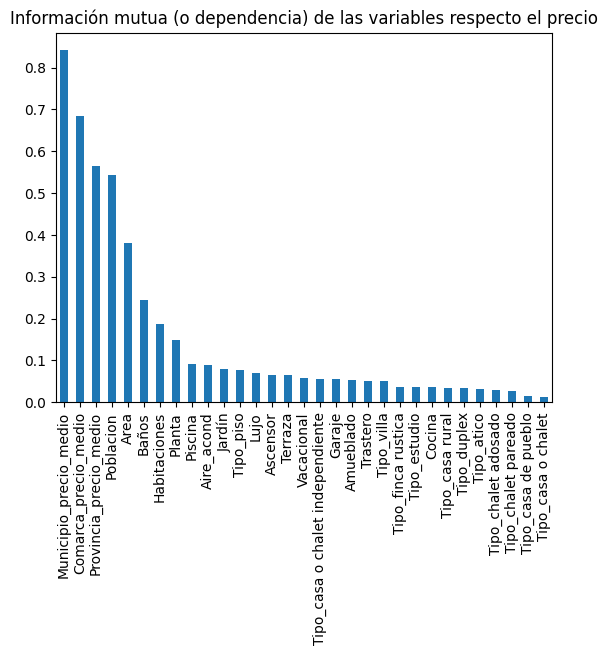

In [178]:
plt.title('Información mutua (o dependencia) de las variables respecto el precio')
mi.plot.bar()
plt.show()

In [179]:
df_mi[df_mi['MI'] < 0.05]

,variable,MI
21,Tipo_finca rustica,0.037492
22,Tipo_estudio,0.037295
23,Cocina,0.036080
24,Tipo_casa rural,0.033863
25,Tipo_duplex,0.033022
26,Tipo_atico,0.032336
27,Tipo_chalet adosado,0.028813
28,Tipo_chalet pareado,0.026051
29,Tipo_casa de pueblo,0.015333
30,Tipo_casa o chalet,0.012105


### 5.3.2. Selección de características

In [180]:
# SIN SELECCIÓN DE VARIABLES
X_train_all = X_train.copy()
X_test_all = X_test.copy()

# CON SELECCIÓN DE VARIABLES
# Con Precio
columns_selected = mi[mi>0.05].index
X_train_seleccion = X_train.loc[: , columns_selected]
X_test_seleccion =  X_test.loc[: , columns_selected]

# 6. Exploración de las variables seleccionadas

La exploración se hará con los datos sin normalizar: df_train y df_test.

In [181]:
X_train_seleccion.columns

Index(['Municipio_precio_medio', 'Comarca_precio_medio',
       'Provincia_precio_medio', 'Poblacion', 'Area', 'Baños', 'Habitaciones',
       'Planta', 'Piscina', 'Aire_acond', 'Jardín', 'Tipo_piso', 'Lujo',
       'Ascensor', 'Terraza', 'Vacacional', 'Tipo_casa o chalet independiente',
       'Garaje', 'Amueblado', 'Trastero', 'Tipo_villa'],
      dtype='object')

In [182]:
num_cols = X_train_seleccion.columns[0:8]
cat_cols = X_train_seleccion.columns[8:len(X_train_seleccion.columns)]

## 6.1. Análisis univariante

In [183]:
df_train_sin_outliers = df_train.query('Outlier == 0')

### 6.1.1. Variable respuesta: Precio

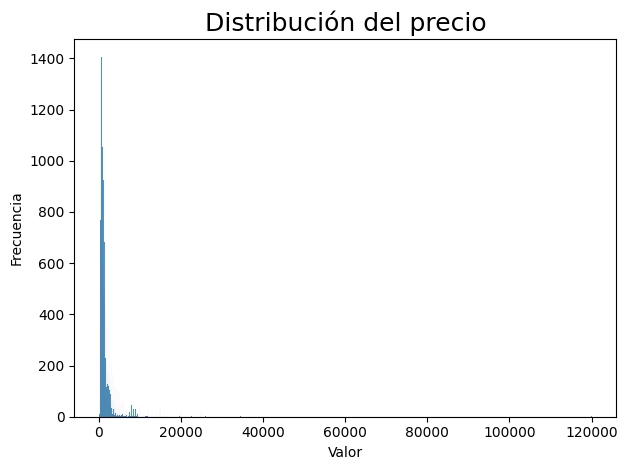

In [184]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(6.4, 4.8))
sns.histplot(df_train['Precio'], ax=axes)
plt.title('Distribución del precio', fontdict = {'size' : 18})
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

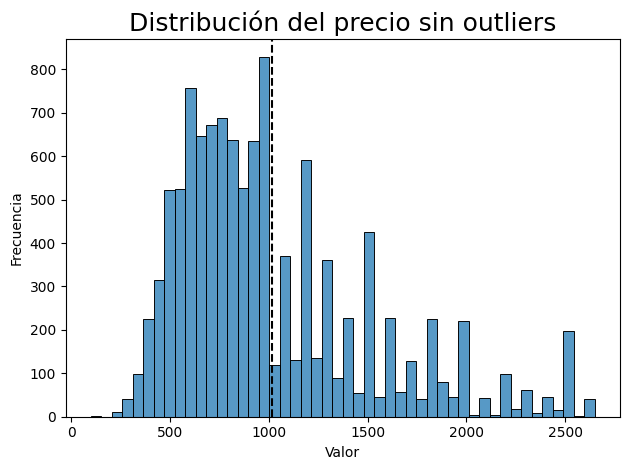

In [185]:
# DISTRIBUCION DEL PRECIO SIN OUTLIERS
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(6.4, 4.8))
sns.histplot(df_train_sin_outliers['Precio'], ax=axes)   # Plot histogram
axes.axvline(df_train_sin_outliers['Precio'].mean(), c='k', linestyle = "--")  # Plot mean
plt.title('Distribución del precio sin outliers', fontdict = {'size' : 18})
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

In [186]:
pd.concat([df_train['Precio'].describe().reset_index().rename({'index' : 'Medida'}, axis = 1),
          df_train_sin_outliers['Precio'].describe().reset_index().rename({'index' : 'Medida', 'Precio' : 'Precio sin outliers'}, axis = 1)['Precio sin outliers']],
          axis = 1)

,Medida,Precio,Precio sin outliers
0,count,16494.000000,11245.000000
1,mean,1775.622681,1014.762939
2,std,2838.913330,495.512299
3,min,100.000000,100.000000
4,25%,750.000000,650.000000
5,50%,1100.000000,887.000000
6,75%,1800.000000,1250.000000
7,max,120000.000000,2650.000000


### 6.1.2. Variables numéricas

In [187]:
df_train_num = df_train[num_cols]
df_train_num.describe()

,Municipio_precio_medio,Comarca_precio_medio,Provincia_precio_medio,Poblacion,Area,Baños,Habitaciones,Planta
count,16494.000000,16494.000000,16494.000000,1.649400e+04,16494.000000,16494.000000,16494.000000,16494.000000
mean,1775.622586,1775.622594,1775.622602,4.759246e+05,118.548260,1.760701,2.577846,2.375076
std,1618.884655,1433.544779,1204.102719,8.777784e+05,113.243647,1.012158,1.479207,2.417904
min,230.000000,300.000000,565.959045,1.500000e+01,10.000000,0.000000,0.000000,-2.000000
25%,897.436340,888.112366,925.576904,2.419700e+04,70.000000,1.000000,2.000000,1.000000
50%,1165.909058,1253.069336,1301.557007,1.439540e+05,90.000000,2.000000,3.000000,2.000000
75%,2257.894775,2304.464355,2332.902344,3.780270e+05,125.000000,2.000000,3.000000,3.000000
max,28500.000000,8964.622070,4969.844727,3.332035e+06,3000.000000,20.000000,87.000000,33.000000


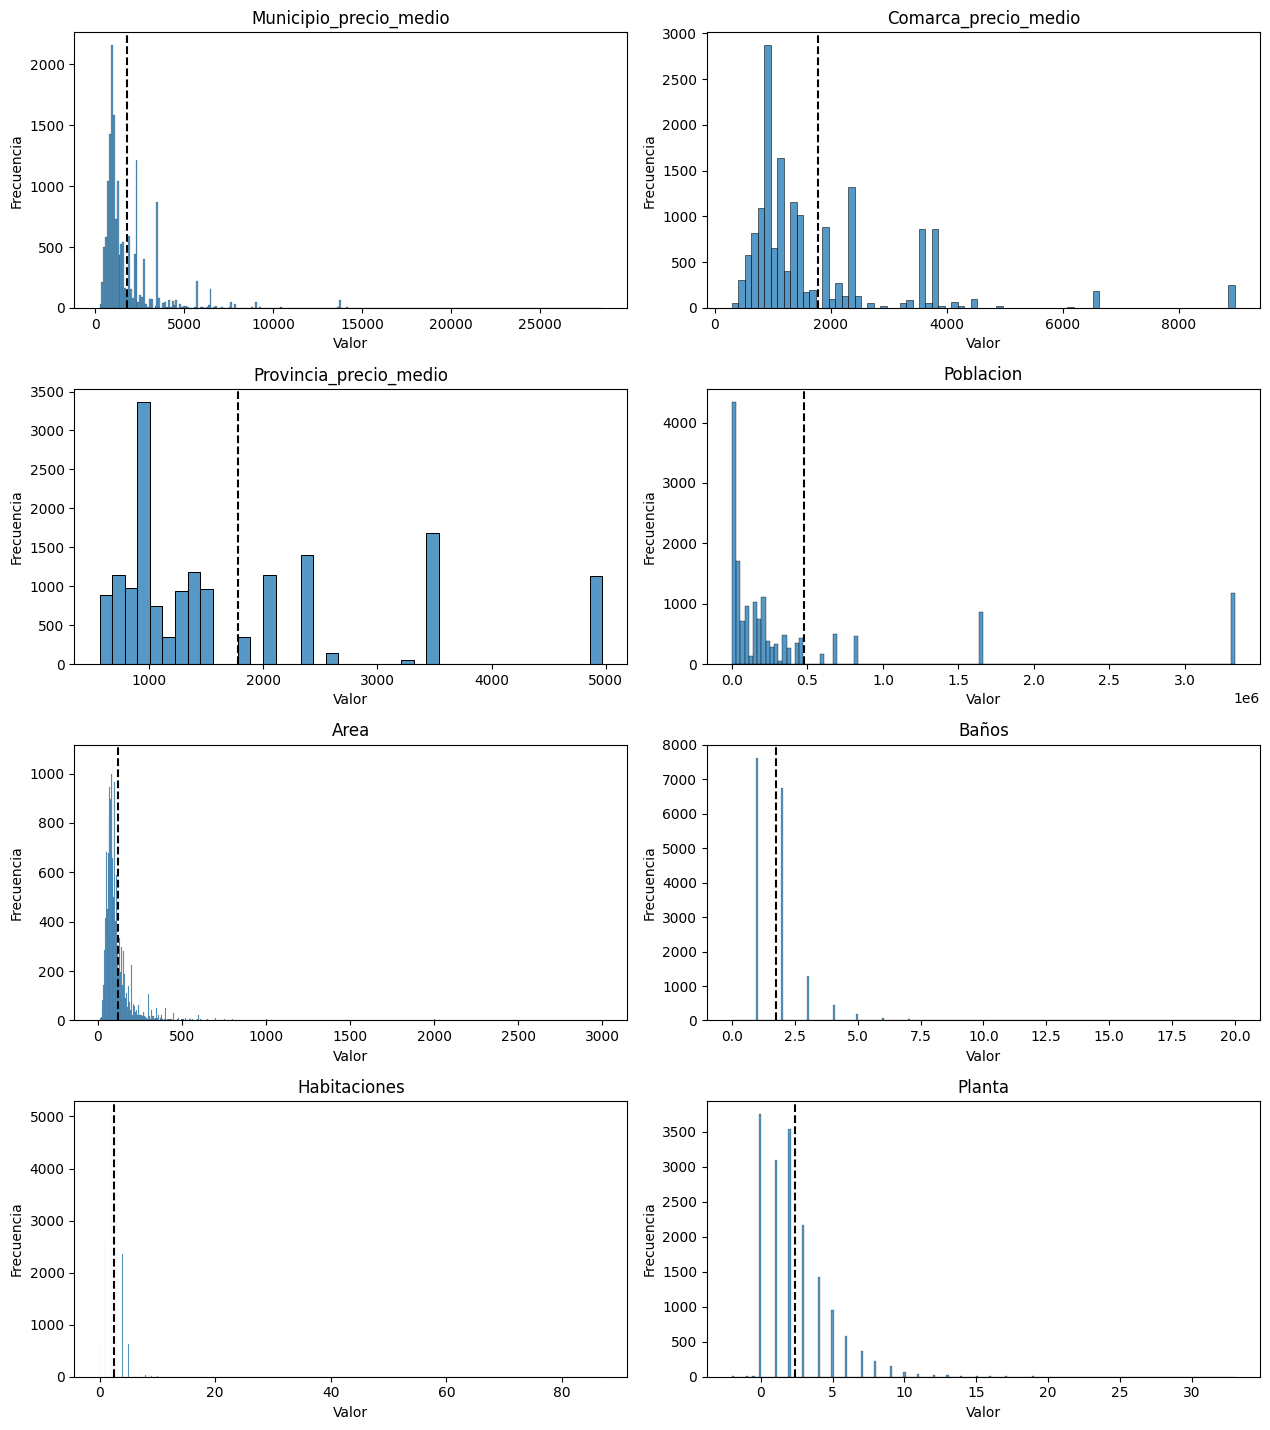

In [188]:
n = math.ceil(df_train_num.shape[1]/2)  # Number of cols

fig, axes = plt.subplots(nrows = n, ncols = 2, figsize=(6.4*2, 4.8*3))  # create subplots

for i, col in enumerate(df_train_num.columns):  # For each column...
    ax = axes.flat[i]
    sns.histplot(df_train_num[col], ax=ax)   # Plot histogram
    ax.axvline(df_train_num[col].mean(), c='k', linestyle = "--")  # Plot mean
    ax.set_title(col)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

### 6.1.3. Variables categóricas

In [189]:
df_train_cat = df_train[cat_cols]

In [190]:
df_describe_cat = pd.DataFrame({}, index = [0,1])
for column in df_train_cat.columns:
    df_describe_cat[column] = df_train_cat[column].value_counts().sort_index().values
df_describe_cat

,Piscina,Aire_acond,Jardín,Tipo_piso,Lujo,Ascensor,Terraza,Vacacional,Tipo_casa o chalet independiente,Garaje,Amueblado,Trastero,Tipo_villa
0,12837,9180,12463,4425,15289,5986,8719,13032,15537,10767,3951,12947,16201
1,3657,7314,4031,12069,1205,10508,7775,3462,957,5727,12543,3547,293


In [191]:
# PORCENTAJES
df_describe_cat = pd.DataFrame({}, index = [0,1])
for column in df_train_cat.columns:
    df_describe_cat[column] = df_train_cat[column].value_counts().sort_index().values / df_train_cat.shape[0]
    df_describe_cat[column] = round(df_describe_cat[column], 3) * 100
    df_describe_cat[column] = df_describe_cat[column].map("{:,.1f}%".format)

df_describe_cat

,Piscina,Aire_acond,Jardín,Tipo_piso,Lujo,Ascensor,Terraza,Vacacional,Tipo_casa o chalet independiente,Garaje,Amueblado,Trastero,Tipo_villa
0,77.8%,55.7%,75.6%,26.8%,92.7%,36.3%,52.9%,79.0%,94.2%,65.3%,24.0%,78.5%,98.2%
1,22.2%,44.3%,24.4%,73.2%,7.3%,63.7%,47.1%,21.0%,5.8%,34.7%,76.0%,21.5%,1.8%


## 6.2. Análisis bivarinte (vs Precio)

### 6.2.1. Numéricas vs Precio

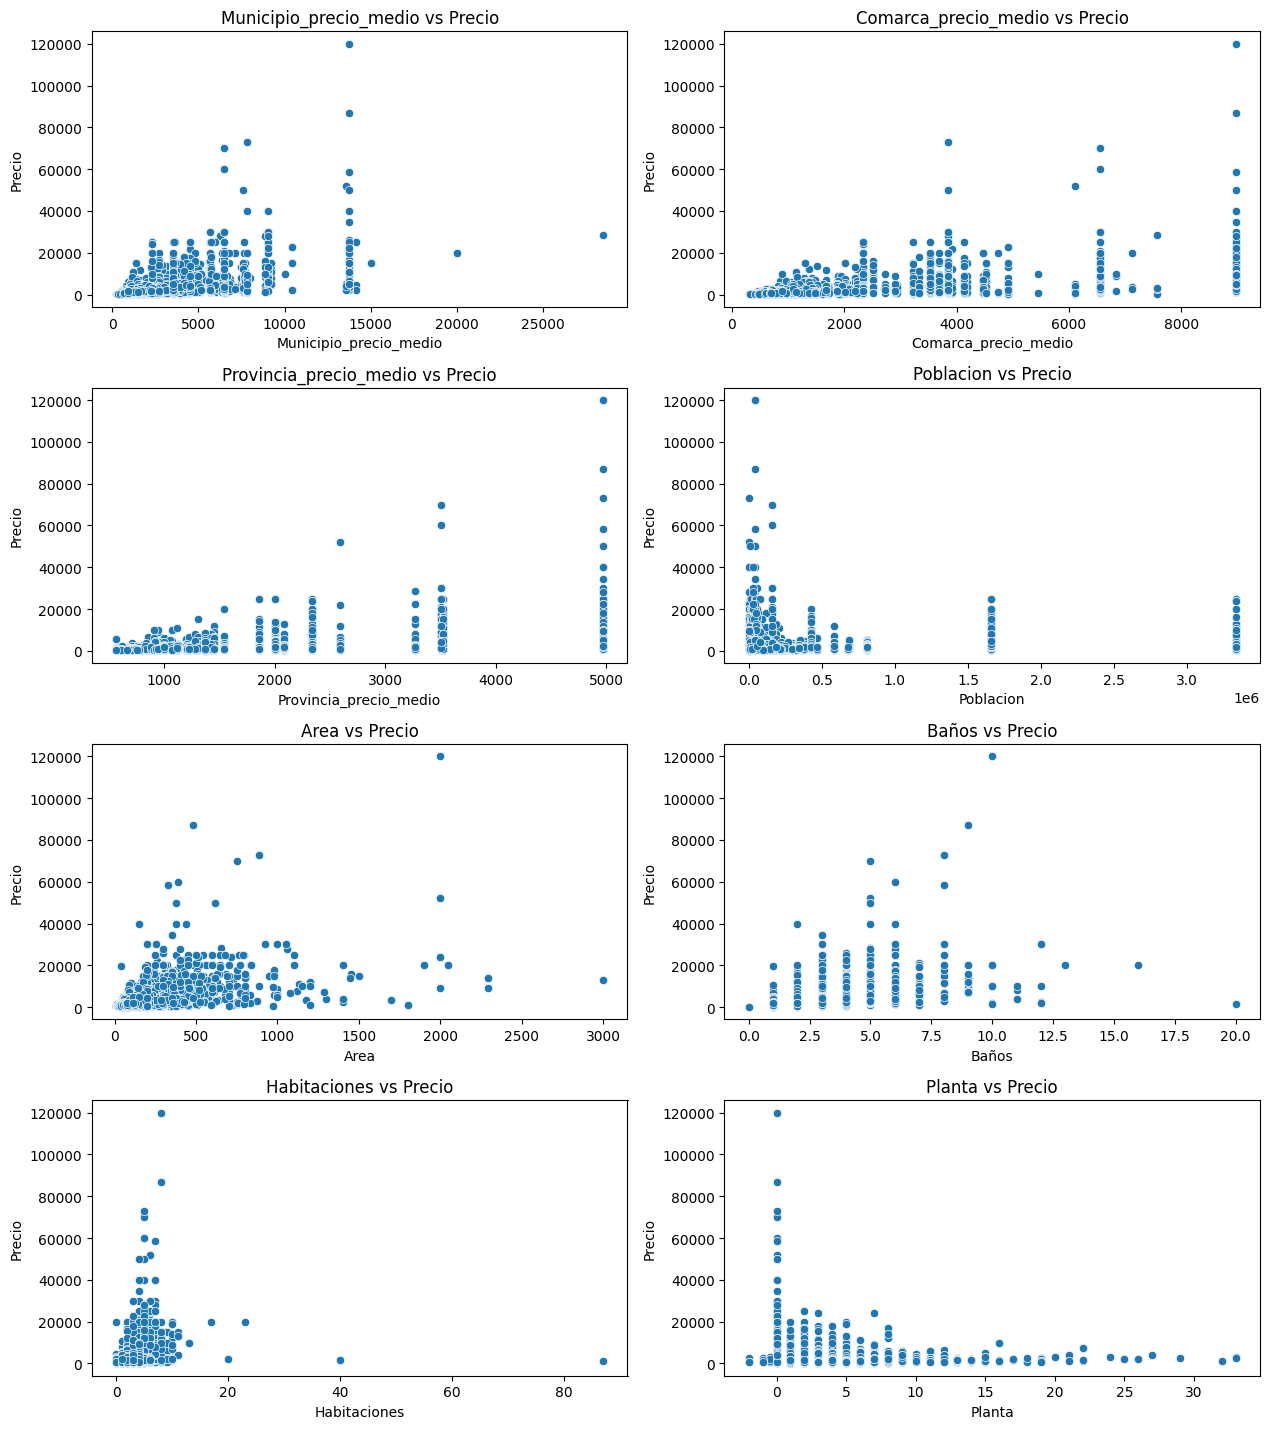

In [192]:
n = math.ceil(df_train_num.shape[1]/2)  # Number of cols

fig, axes = plt.subplots(n, 2, figsize=(6.4*2, 4.8*3))  # create subplots

for i, col in enumerate(df_train_num.columns):  # For each column...
    ax = axes.flat[i]
    sns.scatterplot(y = df_train['Precio'], x = df_train_num[col], ax=ax)   # Plot histogram
    ax.set_title(str(col)+' vs Precio')

plt.tight_layout()
plt.show()

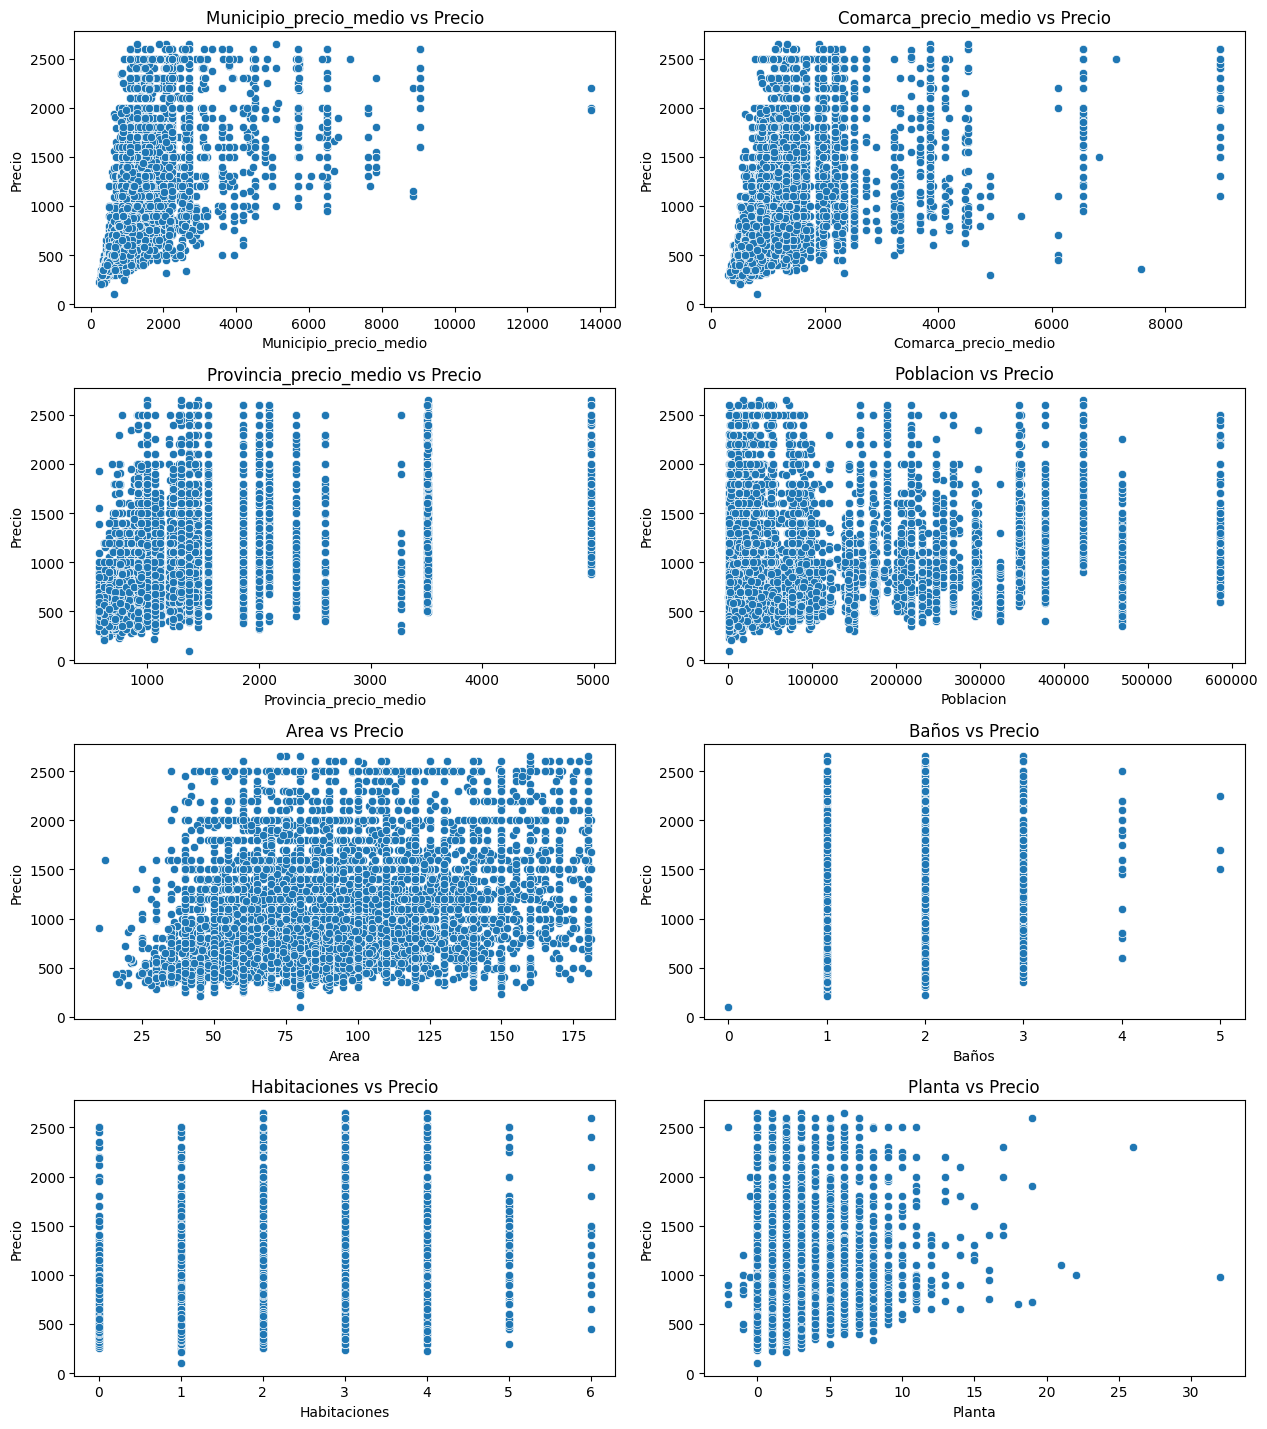

In [193]:
df_train_sin_outliers_num = df_train_sin_outliers[num_cols]

# SIN OUTLIERS
n = math.ceil(df_train_sin_outliers_num.shape[1]/2)  # Number of cols

fig, axes = plt.subplots(n, 2, figsize=(6.4*2, 4.8*3))  # create subplots

for i, col in enumerate(df_train_sin_outliers_num.columns):  # For each column...
    ax = axes.flat[i]
    sns.scatterplot(y = df_train_sin_outliers['Precio'], x = df_train_sin_outliers_num[col], ax=ax)   # Plot histogram
    ax.set_title(str(col)+' vs Precio')

plt.tight_layout()
plt.show()

### 6.2.2. Categóricas vs Precio

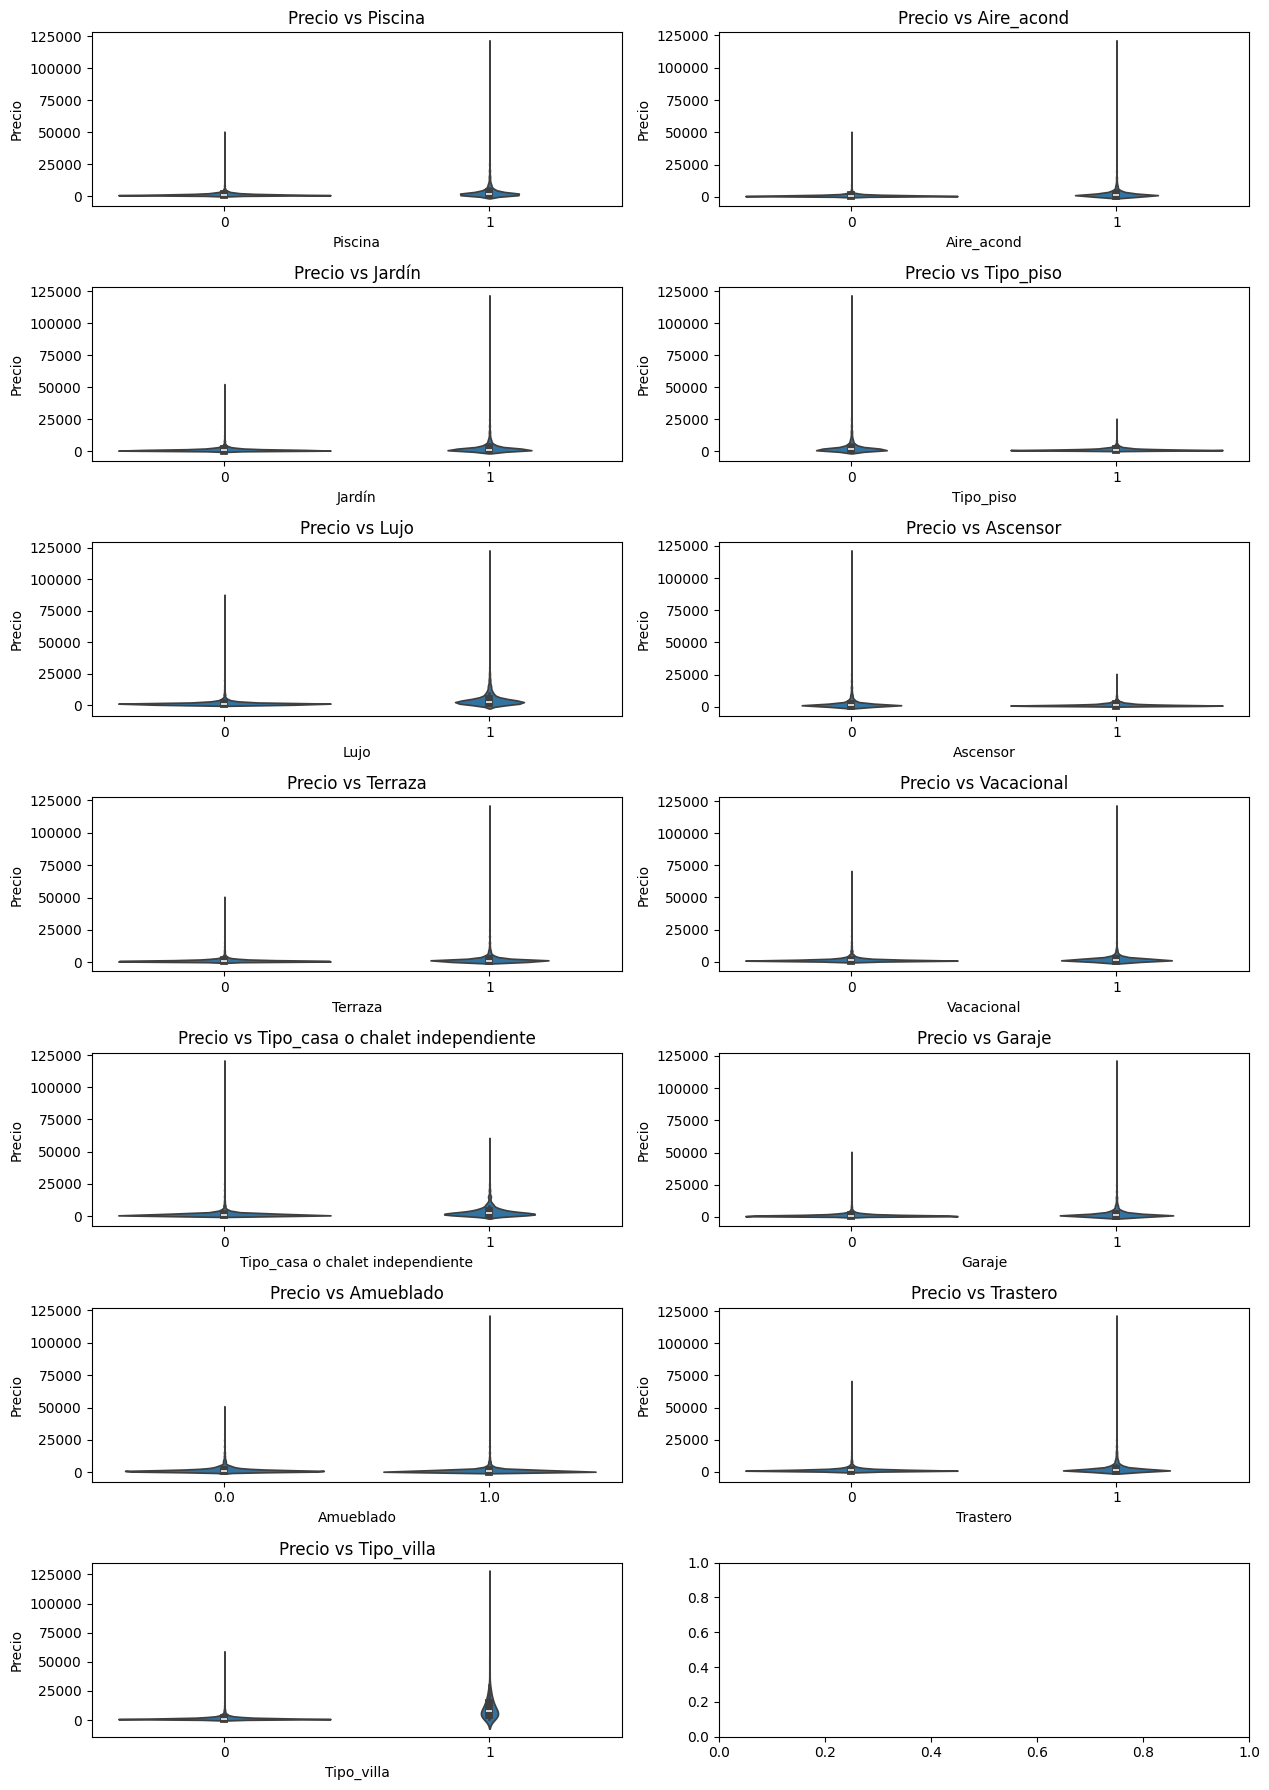

In [194]:
n_filas = math.ceil(df_train_cat.shape[1]/2)  # Number of cols
alto_figura = n_filas * 3

fig, all_axes = plt.subplots(n_filas, 2, figsize=(6.4*2, 4.8*3*1.25))  # create subplots


# Aplanar la matriz de subplots para facilitar la iteración
all_axes = all_axes.reshape(-1)  # Convertir en una lista unidimensional

# Recorrer las variables categóricas y los subplots
for i, (col, ax) in enumerate(zip(df_train_cat.columns, all_axes)):
    # Crear diagrama de cajas para cada variable categórica
    sns.violinplot(
        x = col,
        y = 'Precio',
        data = df_train,
        ax = ax  # Especificar el subplot actual
    )

    # Ajustar título y etiquetas de eje
    ax.set_title('Precio vs ' + str(col))
    ax.set_xlabel(col)
    ax.set_ylabel('Precio')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

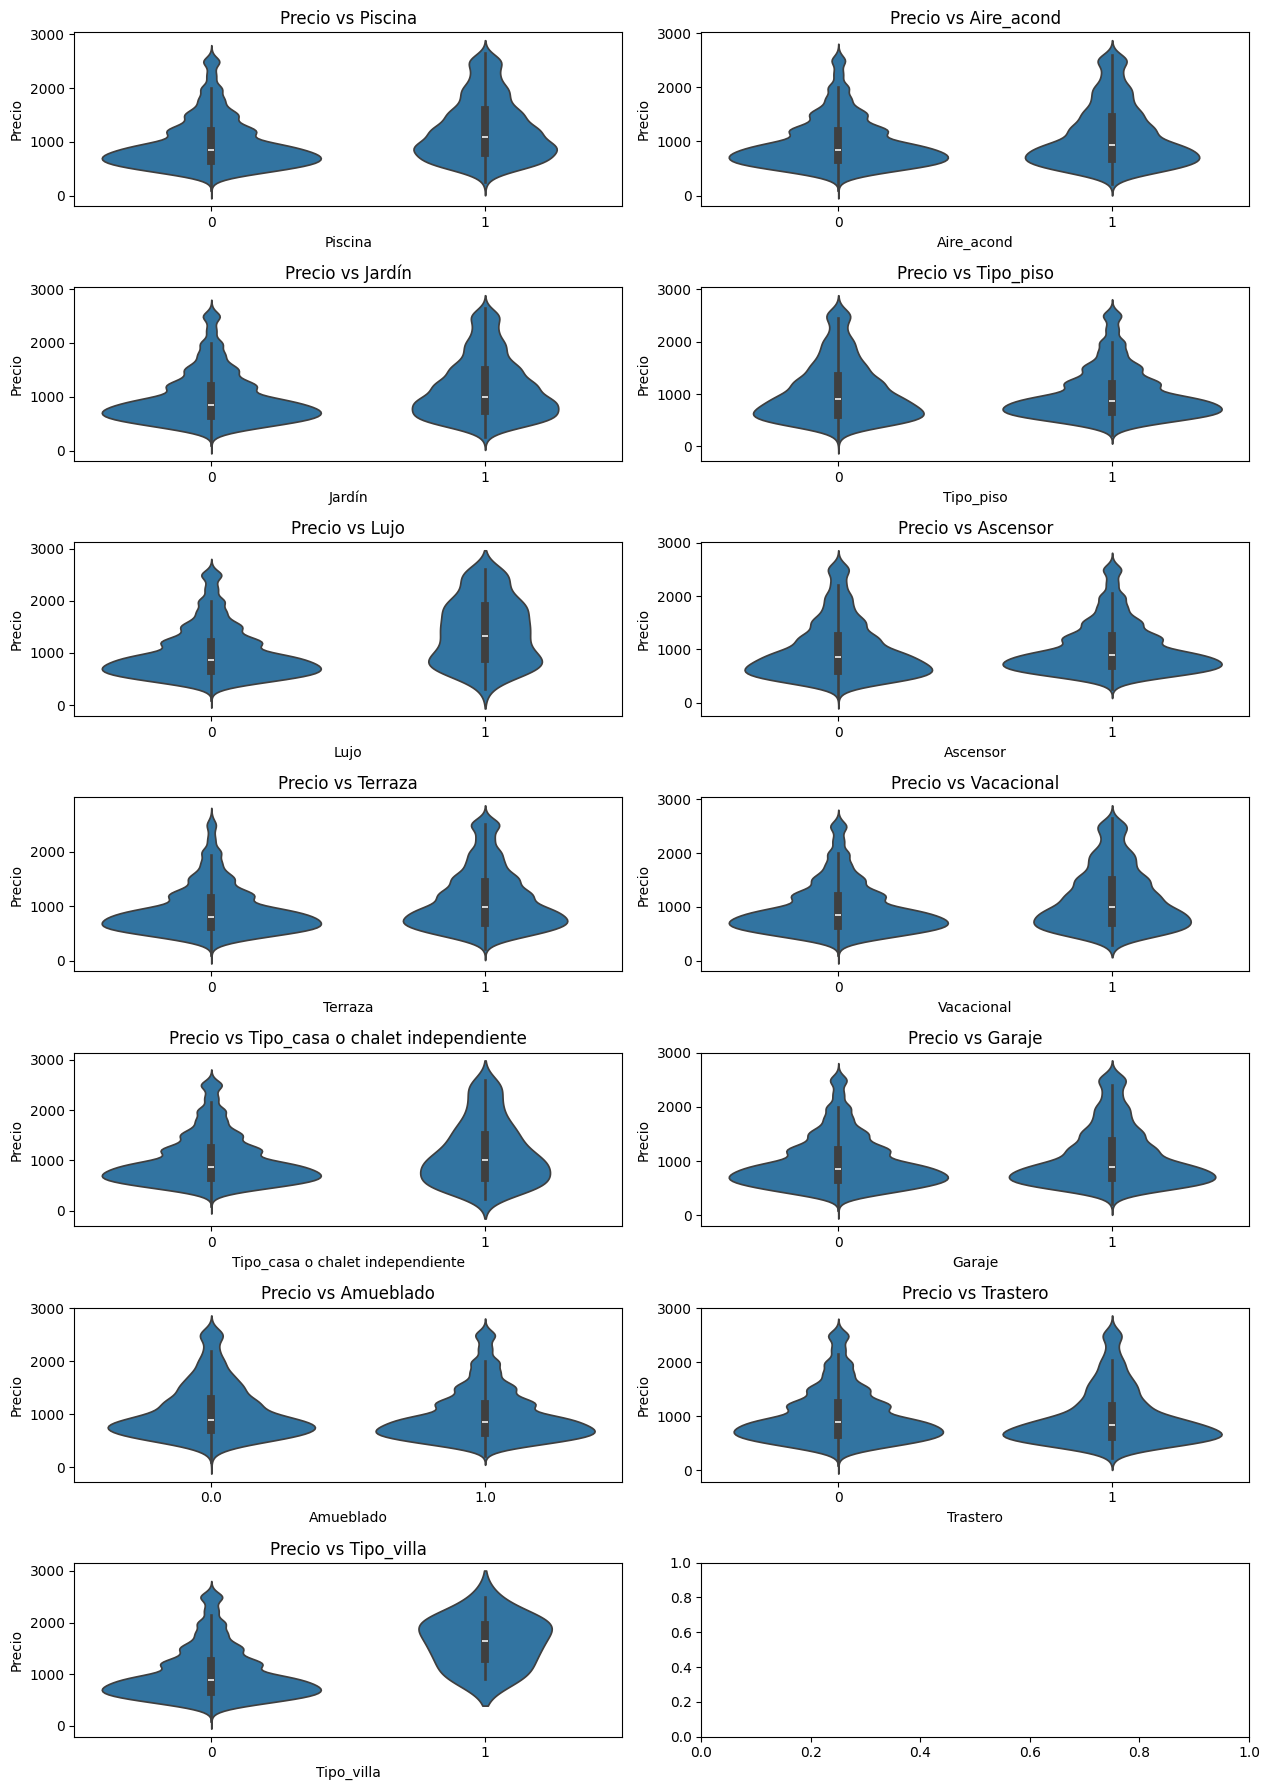

In [195]:
# SIN OUTLIERS 
n_filas = math.ceil(df_train_cat.shape[1]/2)  # Number of cols
alto_figura = n_filas * 3

fig, all_axes = plt.subplots(n_filas, 2, figsize=(6.4*2, 4.8*3*1.25))  # create subplots


# Aplanar la matriz de subplots para facilitar la iteración
all_axes = all_axes.reshape(-1)  # Convertir en una lista unidimensional

# Recorrer las variables categóricas y los subplots
for i, (col, ax) in enumerate(zip(df_train_cat.columns, all_axes)):
    # Crear diagrama de cajas para cada variable categórica
    sns.violinplot(
        x = col,
        y = 'Precio',
        data = df_train.query('Outlier == 0'),
        ax = ax  # Especificar el subplot actual
    )

    # Ajustar título y etiquetas de eje
    ax.set_title('Precio vs ' + str(col))
    ax.set_xlabel(col)
    ax.set_ylabel('Precio')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

## 6.3. Análisis de correlación

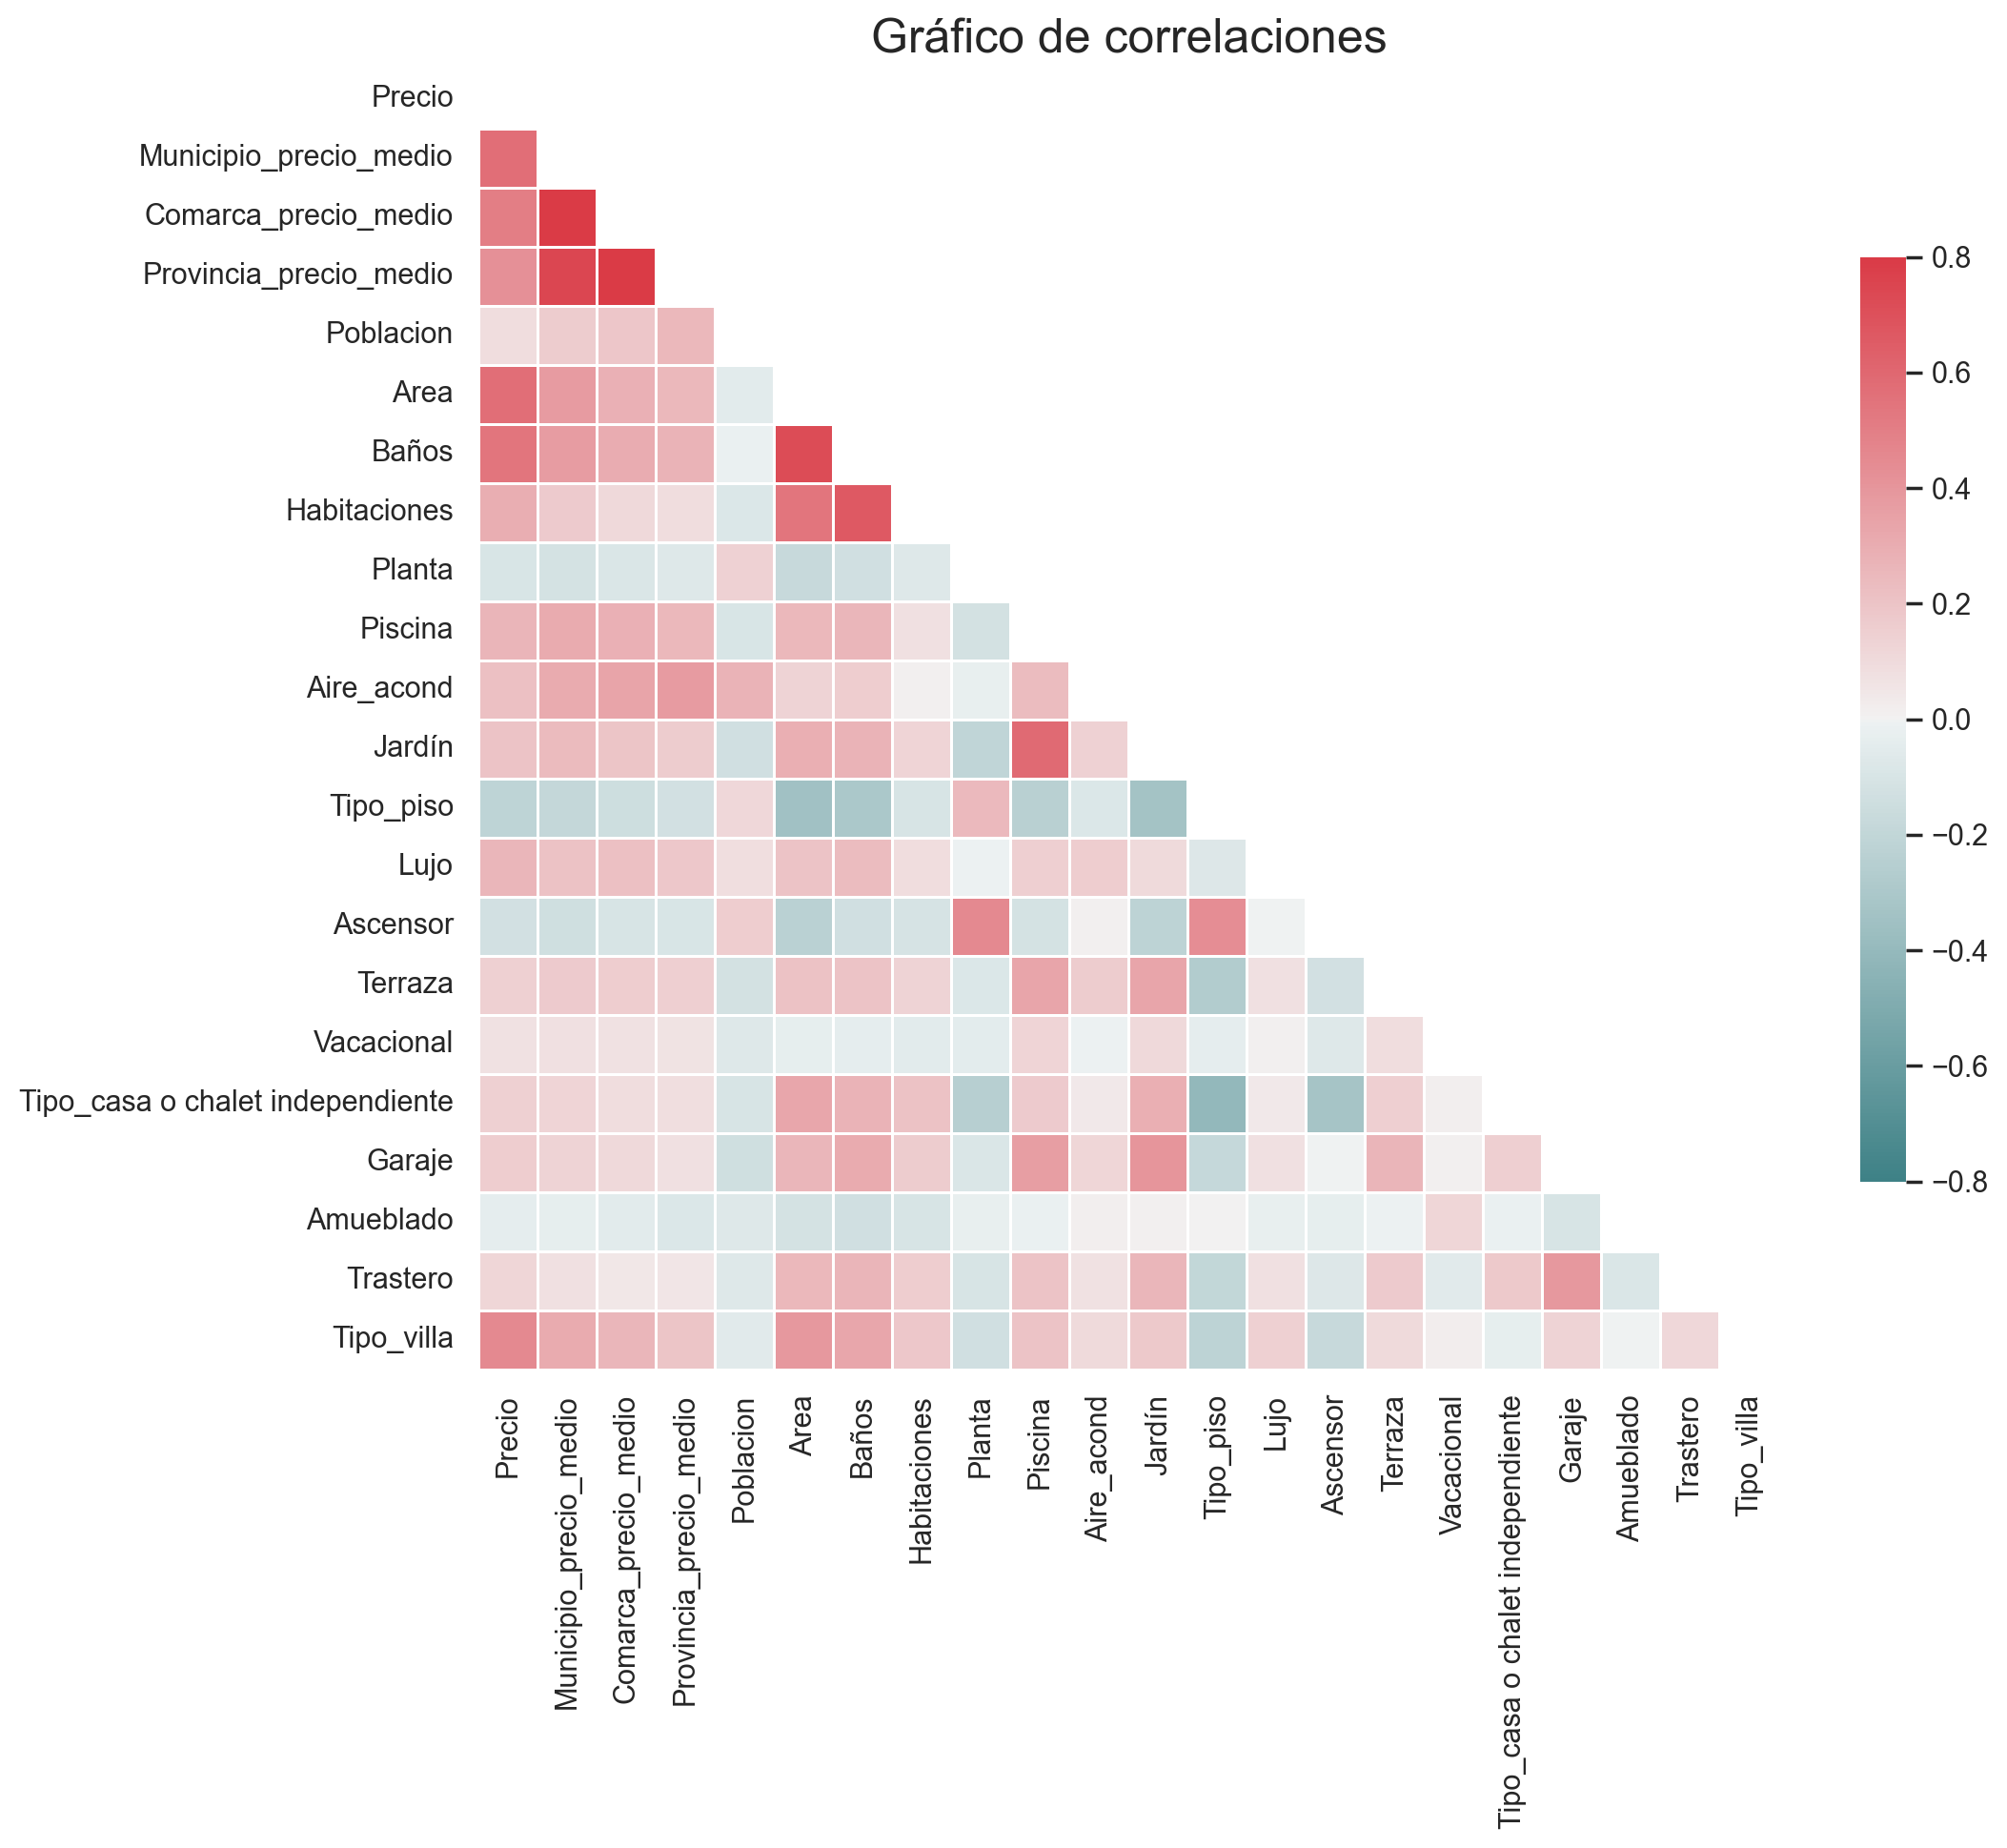

In [196]:
R = pd.concat([df_train['Precio'], df_train_num, df_train_cat], axis = 1).corr()
matrix = np.triu(R)

sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9), dpi = 200)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, cmap=cmap, vmin = -0.8, vmax = 0.8,
            square=True, mask = matrix,
            linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Gráfico de correlaciones', fontdict = {'size' : 18})
plt.show()

# 7. Predicción del precio

In [197]:
X_train = X_train_seleccion.copy()
X_test = X_test_seleccion.copy()

## 7.1. Inicializació métricas evaluación de predicción

In [198]:
scoring = {'R2' : 'r2', 'neg RMSE' : 'neg_root_mean_squared_error', 'neg MAE' : 'neg_mean_absolute_error', 
           'neg MedAE' : 'neg_median_absolute_error'}

algorithm = []
R2_list = [] # higher (best: 1)
RMSE_list = [] # lower (best: 0)
MAE_list = [] # lower (best: 0)
MedAE_list = [] # lower (best: 0)

## 7.2. Algoritmos de regresión

### 7.2.1. Regresion lineal multiple

Con los datos sin normalizar.

In [199]:
X_train_not_scaled = df_train.loc[: , columns_selected]
X_test_not_scaled = df_test.loc[: , columns_selected]

In [200]:
LR_model = LinearRegression()
LR_model.fit(X_train_not_scaled, y_train)
LR_y_predict = LR_model.predict(X_test_not_scaled)

df_models_metrics = pd.DataFrame({'R2' : r2_score(y_test, LR_y_predict).round(2),
                               'RMSE' : root_mean_squared_error(y_test, LR_y_predict).round(2),
                               'MAE' : mean_absolute_error(y_test, LR_y_predict).round(2),
                               'MedAE' : median_absolute_error(y_test, LR_y_predict).round(2)},
                               index = ['Regresión Lineal'])

In [201]:
df_models_metrics.loc[df_models_metrics.index == 'Regresión Lineal']

,R2,RMSE,MAE,MedAE
Regresión Lineal,0.58,1498.87,684.98,368.62


In [202]:
print("Intercept:", LR_model.intercept_)
pd.DataFrame({'coeficiente' : LR_model.coef_}, index = X_train_not_scaled.columns) #.drop('Tipo_piso', axis = 1)

Intercept: -1325.5452553880953


,coeficiente
Municipio_precio_medio,0.456881
Comarca_precio_medio,0.192292
Provincia_precio_medio,-0.077883
Poblacion,0.000166
Area,7.245030
Baños,602.691721
Habitaciones,-140.545664
Planta,25.580813
Piscina,225.169629
Aire_acond,7.464847


### 7.2.2. Árbol de decisión

In [203]:
gs_DT = GridSearchCV(
    DecisionTreeRegressor(random_state = 2022, criterion = 'absolute_error'),
    param_grid = {'min_samples_leaf' : [2, 20], 'min_samples_split' : [2]},
    scoring = scoring,
    n_jobs = -2,
    refit = 'neg MAE',
    cv = 5, # default
)

gs_DT.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(criterion='absolute_error',
                                             random_state=2022),
             n_jobs=-2,
             param_grid={'min_samples_leaf': [2, 20], 'min_samples_split': [2]},
             refit='neg MAE',
             scoring={'R2': 'r2', 'neg MAE': 'neg_mean_absolute_error',
                      'neg MedAE': 'neg_median_absolute_error',
                      'neg RMSE': 'neg_root_mean_squared_error'})

In [204]:
print('Best MAE score:', -gs_DT.best_score_, '\nBest params:', gs_DT.best_params_)

Best MAE score: 562.637658856507 
Best params: {'min_samples_leaf': 20, 'min_samples_split': 2}


In [205]:
DT_regressor = gs_DT.best_estimator_
DT_y_predict = DT_regressor.predict(X_test)

df_models_metrics.loc[len(df_models_metrics)] = [r2_score(y_test, DT_y_predict).round(2), 
                                                 root_mean_squared_error(y_test, DT_y_predict).round(2),
                                                 mean_absolute_error(y_test, DT_y_predict).round(2), 
                                                 median_absolute_error(y_test, DT_y_predict).round(2)]
df_models_metrics.rename({1 : 'Árbol de Decisión'}, axis = 0, inplace = True)

In [206]:
df_models_metrics.loc[df_models_metrics.index == 'Árbol de Decisión']

,R2,RMSE,MAE,MedAE
Árbol de Decisión,0.62,1423.72,494.33,200.0


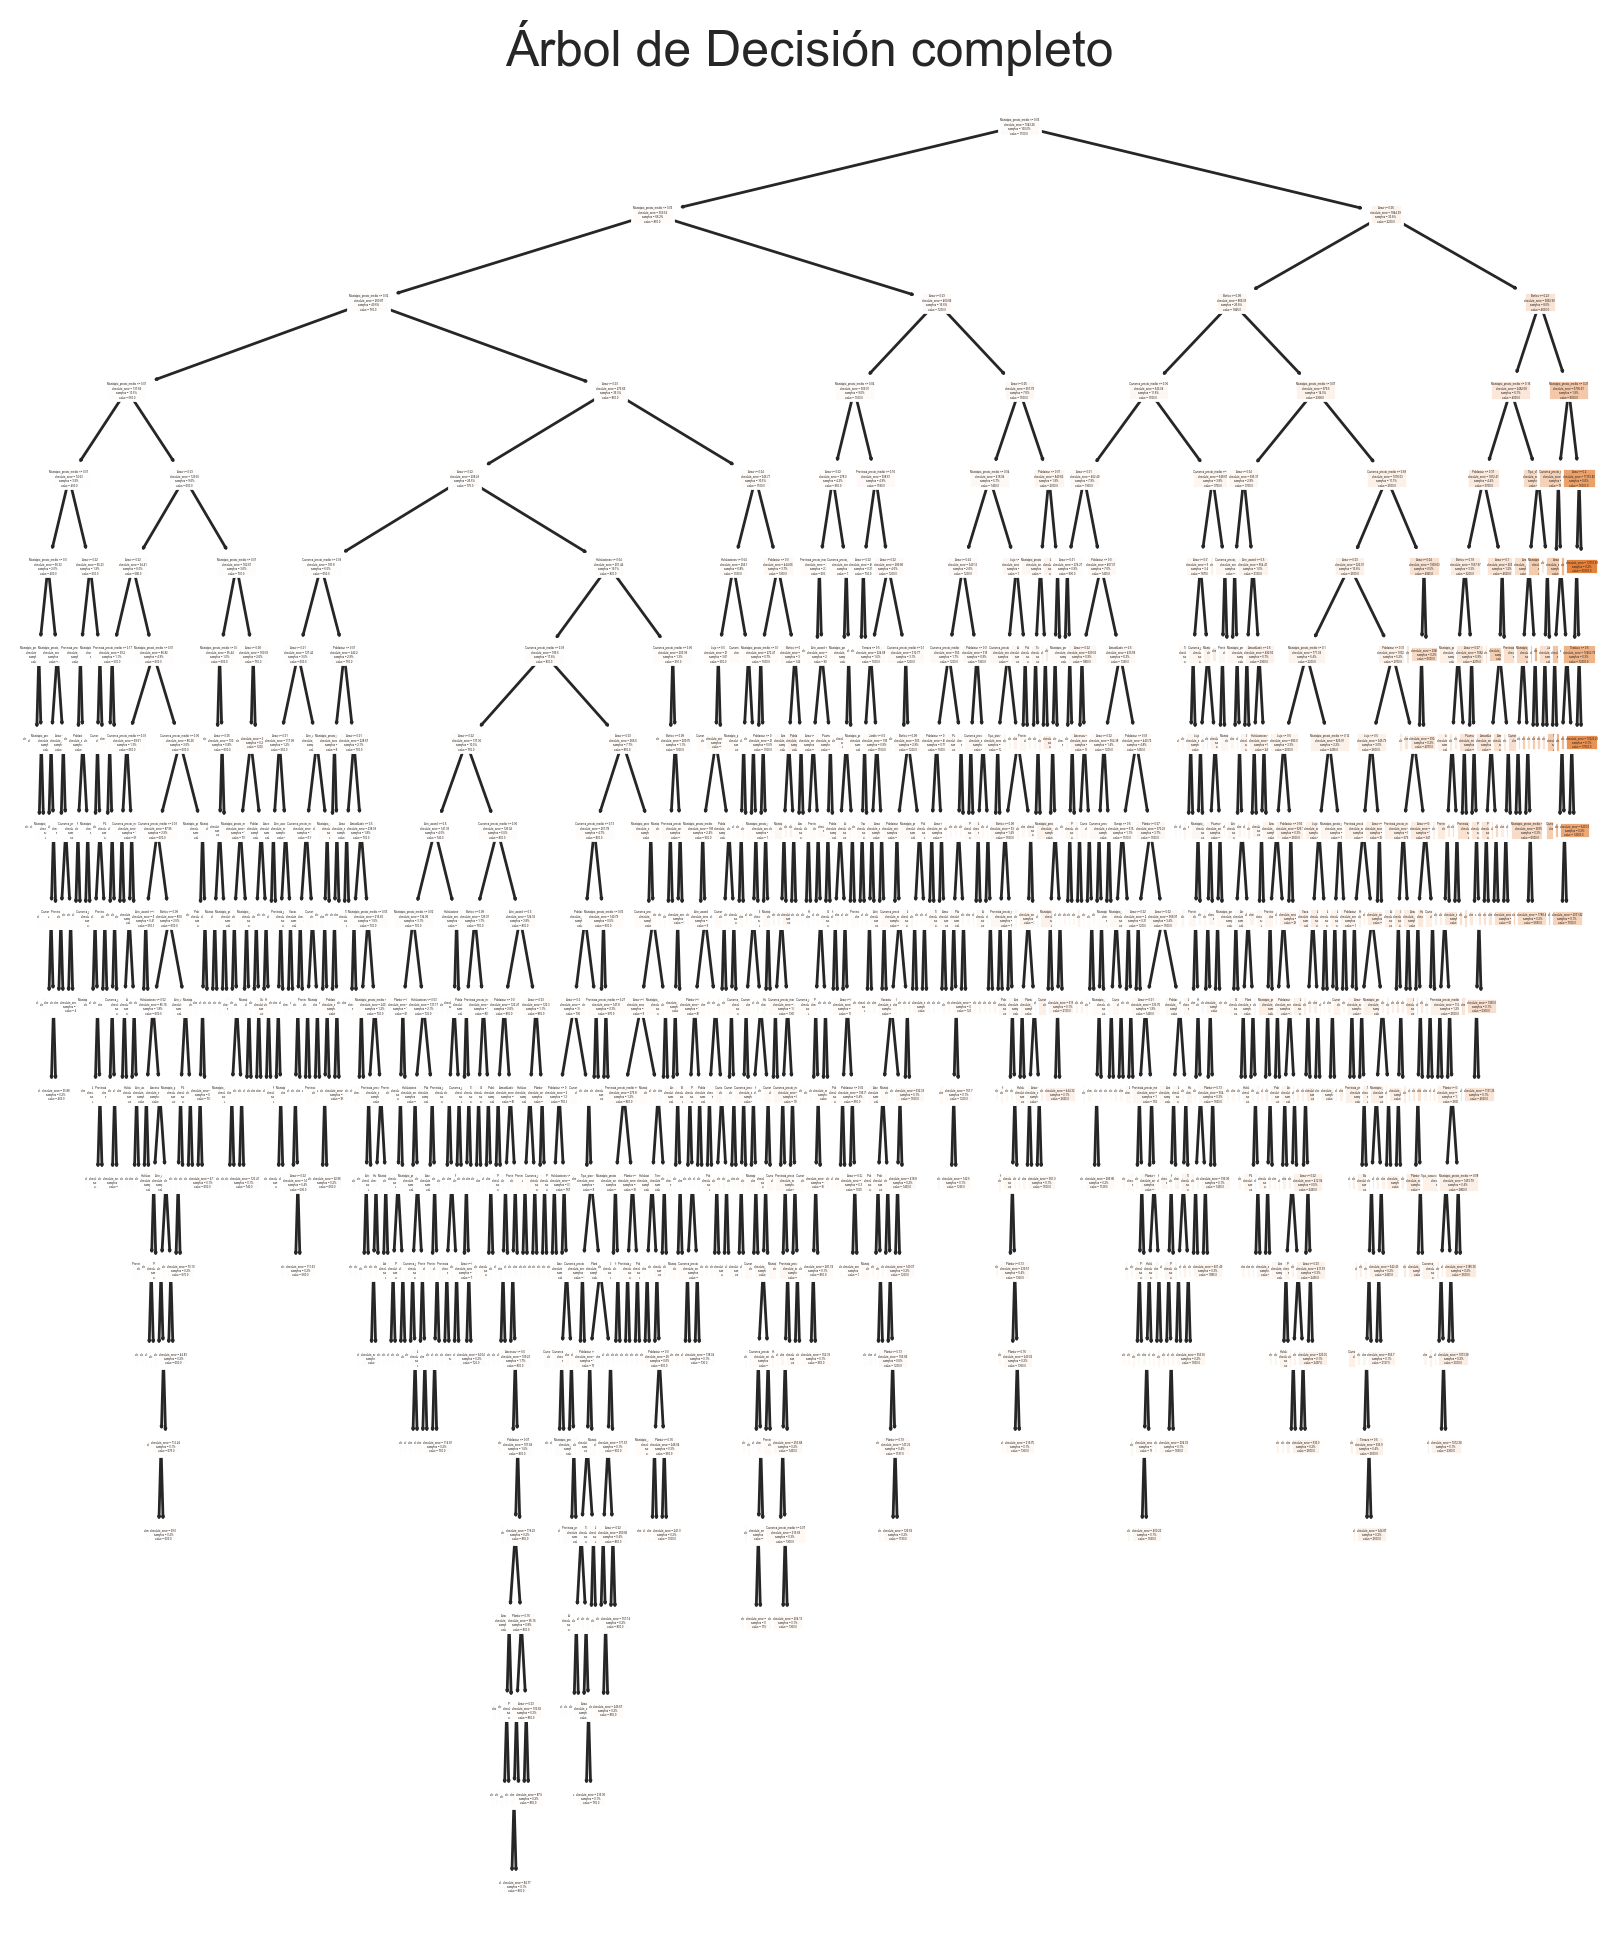

In [207]:
plt.figure(figsize=(10, 12), dpi = 200)
plot_tree(DT_regressor, feature_names = X_train.columns, proportion = True, 
               precision = 2, filled = True)
plt.title('Árbol de Decisión completo', fontdict = {'size' : 18})
plt.show()

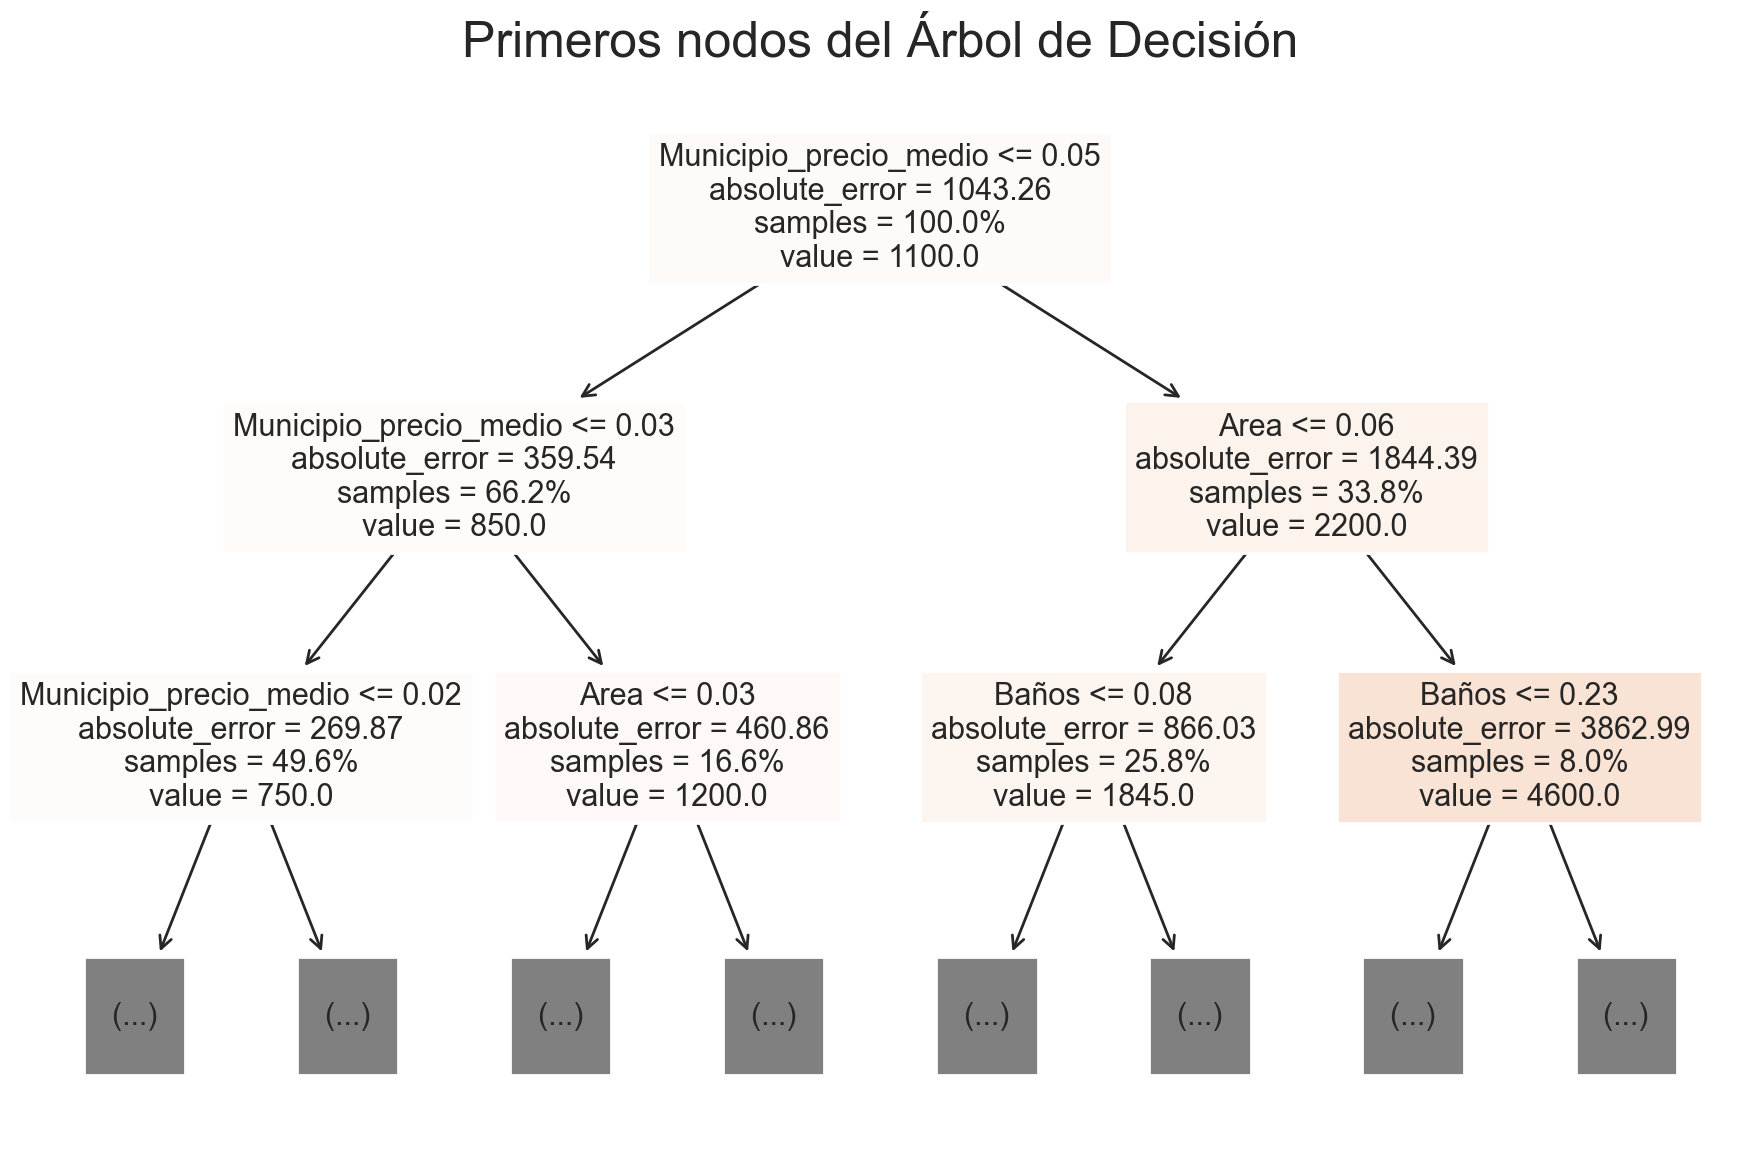

In [208]:
plt.figure(figsize=(11, 7), dpi = 200)
plot_tree(DT_regressor, max_depth = 2, feature_names = X_train.columns, proportion = True, 
               precision = 2, filled = True
               , fontsize = 11
               )
plt.title('Primeros nodos del Árbol de Decisión', fontdict = {'size' : 18})
plt.show()

### 7.2.3. Random Forest

In [209]:
gs_RF = GridSearchCV(
    RandomForestRegressor(random_state = 2022),
    param_grid = {'n_estimators' : [100, 125], 'min_samples_split' : [2], 'min_samples_leaf' : [2, 10]},
    scoring = scoring,
    n_jobs = -2,
    refit = 'neg MAE',
    cv = 5, # default
)

gs_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2022),
             n_jobs=-2,
             param_grid={'min_samples_leaf': [2, 10], 'min_samples_split': [2],
                         'n_estimators': [100, 125]},
             refit='neg MAE',
             scoring={'R2': 'r2', 'neg MAE': 'neg_mean_absolute_error',
                      'neg MedAE': 'neg_median_absolute_error',
                      'neg RMSE': 'neg_root_mean_squared_error'})

In [210]:
print('Best MAE score:', -gs_RF.best_score_, '\nBest params:', gs_RF.best_params_)

Best MAE score: 530.4770257198415 
Best params: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 125}


In [211]:
RF_regressor = gs_RF.best_estimator_
RF_y_predict = RF_regressor.predict(X_test)

df_models_metrics.loc[len(df_models_metrics)] = [r2_score(y_test, RF_y_predict).round(2), 
                                                 root_mean_squared_error(y_test, RF_y_predict).round(2),
                                                 mean_absolute_error(y_test, RF_y_predict).round(2), 
                                                 median_absolute_error(y_test, RF_y_predict).round(2)]
df_models_metrics.rename({2 : 'Random Forest'}, axis = 0, inplace = True)

In [212]:
df_models_metrics.loc[df_models_metrics.index == 'Random Forest']

,R2,RMSE,MAE,MedAE
Random Forest,0.65,1373.91,480.33,183.13


### 7.2.4. Gradient Tree Boosting

In [213]:
gs_GB = GridSearchCV(
    GradientBoostingRegressor(random_state = 2022, loss = 'absolute_error'),
    param_grid = {'learning_rate' : [0.1, 0.2, 0.3], 'n_estimators' : [100, 300], 'min_samples_split' : [2], 
                  'min_samples_leaf' : [2, 60]},
    scoring = scoring,
    n_jobs = -2,
    refit = 'neg MAE',
    cv = 5,# default
)

gs_GB.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='absolute_error',
                                                 random_state=2022),
             n_jobs=-2,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'min_samples_leaf': [2, 60], 'min_samples_split': [2],
                         'n_estimators': [100, 300]},
             refit='neg MAE',
             scoring={'R2': 'r2', 'neg MAE': 'neg_mean_absolute_error',
                      'neg MedAE': 'neg_median_absolute_error',
                      'neg RMSE': 'neg_root_mean_squared_error'})

In [214]:
print('Best MAE score:', -gs_GB.best_score_, '\nBest params:', gs_GB.best_params_)

Best MAE score: 509.3697573829362 
Best params: {'learning_rate': 0.2, 'min_samples_leaf': 60, 'min_samples_split': 2, 'n_estimators': 300}


In [215]:
GB_regressor = gs_GB.best_estimator_
GB_y_predict = GB_regressor.predict(X_test)

df_models_metrics.loc[len(df_models_metrics)] = [r2_score(y_test, GB_y_predict).round(2), 
                                                 root_mean_squared_error(y_test, GB_y_predict).round(2),
                                                 mean_absolute_error(y_test, GB_y_predict).round(2), 
                                                 median_absolute_error(y_test, GB_y_predict).round(2)]
df_models_metrics.rename({3 : 'Gradient Tree Boost'}, axis = 0, inplace = True)

In [216]:
df_models_metrics.loc[df_models_metrics.index == 'Gradient Tree Boost']

,R2,RMSE,MAE,MedAE
Gradient Tree Boost,0.67,1338.91,444.97,164.66


### 7.2.5. AdaBoost Regression with Decision Trees

In [217]:
gs_AB_DT = GridSearchCV(
    AdaBoostRegressor(DecisionTreeRegressor(max_depth = None, min_samples_leaf = 20, min_samples_split = 2), random_state = 2022),    
    param_grid = {'n_estimators' : [30, 35, 40], 
                  'learning_rate' : [.0075, .01, .075], 
                  'loss' : ['square', 'exponential']},
    scoring = scoring,
    n_jobs = -2,
    refit = 'neg MAE',
    cv = 5, # default
    )

gs_AB_DT.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=20),
                                         random_state=2022),
             n_jobs=-2,
             param_grid={'learning_rate': [0.0075, 0.01, 0.075],
                         'loss': ['square', 'exponential'],
                         'n_estimators': [30, 35, 40]},
             refit='neg MAE',
             scoring={'R2': 'r2', 'neg MAE': 'neg_mean_absolute_error',
                      'neg MedAE': 'neg_median_absolute_error',
                      'neg RMSE': 'neg_root_mean_squared_error'})

In [218]:
print('Best MAE score:', -gs_AB_DT.best_score_, '\nBest params:', gs_AB_DT.best_params_)

Best MAE score: 529.0937945777486 
Best params: {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 40}


In [219]:
AB_DT_regressor = gs_AB_DT.best_estimator_
AB_DT_y_predict = AB_DT_regressor.predict(X_test)

df_models_metrics.loc[len(df_models_metrics)] = [r2_score(y_test, AB_DT_y_predict).round(2), 
                                                 root_mean_squared_error(y_test, AB_DT_y_predict).round(2),
                                                 mean_absolute_error(y_test, AB_DT_y_predict).round(2), 
                                                 median_absolute_error(y_test, AB_DT_y_predict).round(2)]
df_models_metrics.rename({4 : 'AdaBoost'}, axis = 0, inplace = True)

In [220]:
df_models_metrics.loc[df_models_metrics.index == 'AdaBoost']

,R2,RMSE,MAE,MedAE
AdaBoost,0.66,1350.85,473.87,189.65


### 7.2.6. SVM

#### 7.2.6.1. SVM Lineal

In [221]:
gs_SVR_linear = GridSearchCV(
    SVR(kernel = 'linear'),
    param_grid = {'C' : [200], 'epsilon' : [10, 20]},
    scoring = scoring,
    n_jobs = -2,
    refit = 'neg MAE',
    cv = 5 # default
)

gs_SVR_linear.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(kernel='linear'), n_jobs=-2,
             param_grid={'C': [200], 'epsilon': [10, 20]}, refit='neg MAE',
             scoring={'R2': 'r2', 'neg MAE': 'neg_mean_absolute_error',
                      'neg MedAE': 'neg_median_absolute_error',
                      'neg RMSE': 'neg_root_mean_squared_error'})

In [222]:
print('Best MAE score:', -gs_SVR_linear.best_score_, '\nBest params:', gs_SVR_linear.best_params_)

Best MAE score: 636.6412738318305 
Best params: {'C': 200, 'epsilon': 20}


In [223]:
SVR_linear = gs_SVR_linear.best_estimator_
SVR_linear_y_predict = SVR_linear.predict(X_test)

df_models_metrics.loc[len(df_models_metrics)] = [r2_score(y_test, SVR_linear_y_predict).round(2), 
                                                 root_mean_squared_error(y_test, SVR_linear_y_predict).round(2),
                                                 mean_absolute_error(y_test, SVR_linear_y_predict).round(2), 
                                                 median_absolute_error(y_test, SVR_linear_y_predict).round(2)]
df_models_metrics.rename({5 : 'SVM Lineal'}, axis = 0, inplace = True)

In [224]:
df_models_metrics.loc[df_models_metrics.index == 'SVM Lineal']

,R2,RMSE,MAE,MedAE
SVM Lineal,0.48,1665.04,573.11,218.02


#### 7.2.6.2. SVR Polinómico

In [225]:
gs_SVR_poly = GridSearchCV( # como tarda mucho con cada combinación, solo dejo los mejores hiperparametros
    SVR(kernel = 'poly'),
    param_grid = {'C' : [200], 'epsilon' : [50], 'degree' : [5]},
    scoring = scoring,
    n_jobs = -2,
    refit = 'neg MAE',
    cv = 5 # default
)

gs_SVR_poly.fit(X_train, y_train)

# tarda 30s por iteración

GridSearchCV(cv=5, estimator=SVR(kernel='poly'), n_jobs=-2,
             param_grid={'C': [200], 'degree': [5], 'epsilon': [50]},
             refit='neg MAE',
             scoring={'R2': 'r2', 'neg MAE': 'neg_mean_absolute_error',
                      'neg MedAE': 'neg_median_absolute_error',
                      'neg RMSE': 'neg_root_mean_squared_error'})

In [226]:
print('Best MAE score:', -gs_SVR_poly.best_score_, '\nBest params:', gs_SVR_poly.best_params_)

Best MAE score: 603.4507569934992 
Best params: {'C': 200, 'degree': 5, 'epsilon': 50}


In [227]:
SVR_poly = gs_SVR_poly.best_estimator_
SVR_poly_y_predict = SVR_poly.predict(X_test)

df_models_metrics.loc[len(df_models_metrics)] = [r2_score(y_test, SVR_poly_y_predict).round(2), 
                                                 root_mean_squared_error(y_test, SVR_poly_y_predict).round(2),
                                                 mean_absolute_error(y_test, SVR_poly_y_predict).round(2), 
                                                 median_absolute_error(y_test, SVR_poly_y_predict).round(2)]
df_models_metrics.rename({6 : 'SVM Polinómico'}, axis = 0, inplace = True)

In [228]:
df_models_metrics.loc[df_models_metrics.index == 'SVM Polinómico']

,R2,RMSE,MAE,MedAE
SVM Polinómico,0.62,1421.66,516.14,213.35


## 7.3. Evaluación de los modelos de predicción

In [229]:
df_models_metrics

,R2,RMSE,MAE,MedAE
Regresión Lineal,0.58,1498.87,684.98,368.62
Árbol de Decisión,0.62,1423.72,494.33,200.00
Random Forest,0.65,1373.91,480.33,183.13
Gradient Tree Boost,0.67,1338.91,444.97,164.66
AdaBoost,0.66,1350.85,473.87,189.65
SVM Lineal,0.48,1665.04,573.11,218.02
SVM Polinómico,0.62,1421.66,516.14,213.35


In [230]:
y_train.mean()

1775.6227

In [231]:
444.97 / y_train.mean()

0.2505994121642929

## 7.4. Interpretación del modelo final

### 7.4.1. Residuos

In [ ]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6), dpi = 200)

plt.scatter(GB_y_predict, y_test, color="darkblue") # fitted vs residuals
plt.axline((0, 0), (1, 1), linewidth=2, color='darkgray', linestyle='--')
plt.ylabel('Actual values')
plt.xlabel('Predicted Values')
plt.title('Predicted vs Actual values')
plt.show()

In [ ]:
# CORTANDO EN 10.000 €

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6), dpi = 200)

plt.scatter(GB_y_predict, y_test, color="darkblue") # fitted vs residuals
plt.axline((0, 0), (1, 1), linewidth=2, color='darkgray', linestyle='--')
plt.ylabel('Actual values')
plt.ylim(0, 10000)
plt.xlim(0, 15000)
plt.xlabel('Predicted Values')
plt.title('Predicted vs Actual values\nhasta 10.000 € de precio real')
plt.show()

### 7.4.2. Importancia

In [232]:
GB_importance_df = pd.DataFrame({'Importancia' : GB_regressor.feature_importances_}, index = GB_regressor.feature_names_in_)\
    .sort_values('Importancia', ascending = False)
GB_importance_df

,Importancia
Municipio_precio_medio,0.588804
Area,0.143419
Comarca_precio_medio,0.062624
Baños,0.047235
Poblacion,0.045235
Provincia_precio_medio,0.028513
Habitaciones,0.020621
Lujo,0.013435
Aire_acond,0.010402
Piscina,0.007440


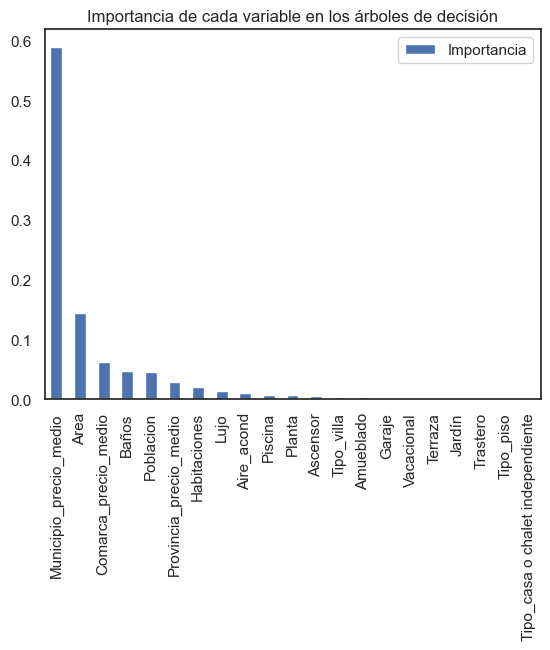

In [233]:
GB_importance_df.plot.bar()
plt.title('Importancia de cada variable en los árboles de decisión')
plt.show()

In [234]:
var_importantes = GB_importance_df[GB_importance_df['Importancia'] > 0.02].index

In [235]:
var_importantes

Index(['Municipio_precio_medio', 'Area', 'Comarca_precio_medio', 'Baños',
       'Poblacion', 'Provincia_precio_medio', 'Habitaciones'],
      dtype='object')

### 7.4.3. Dependencia parcial

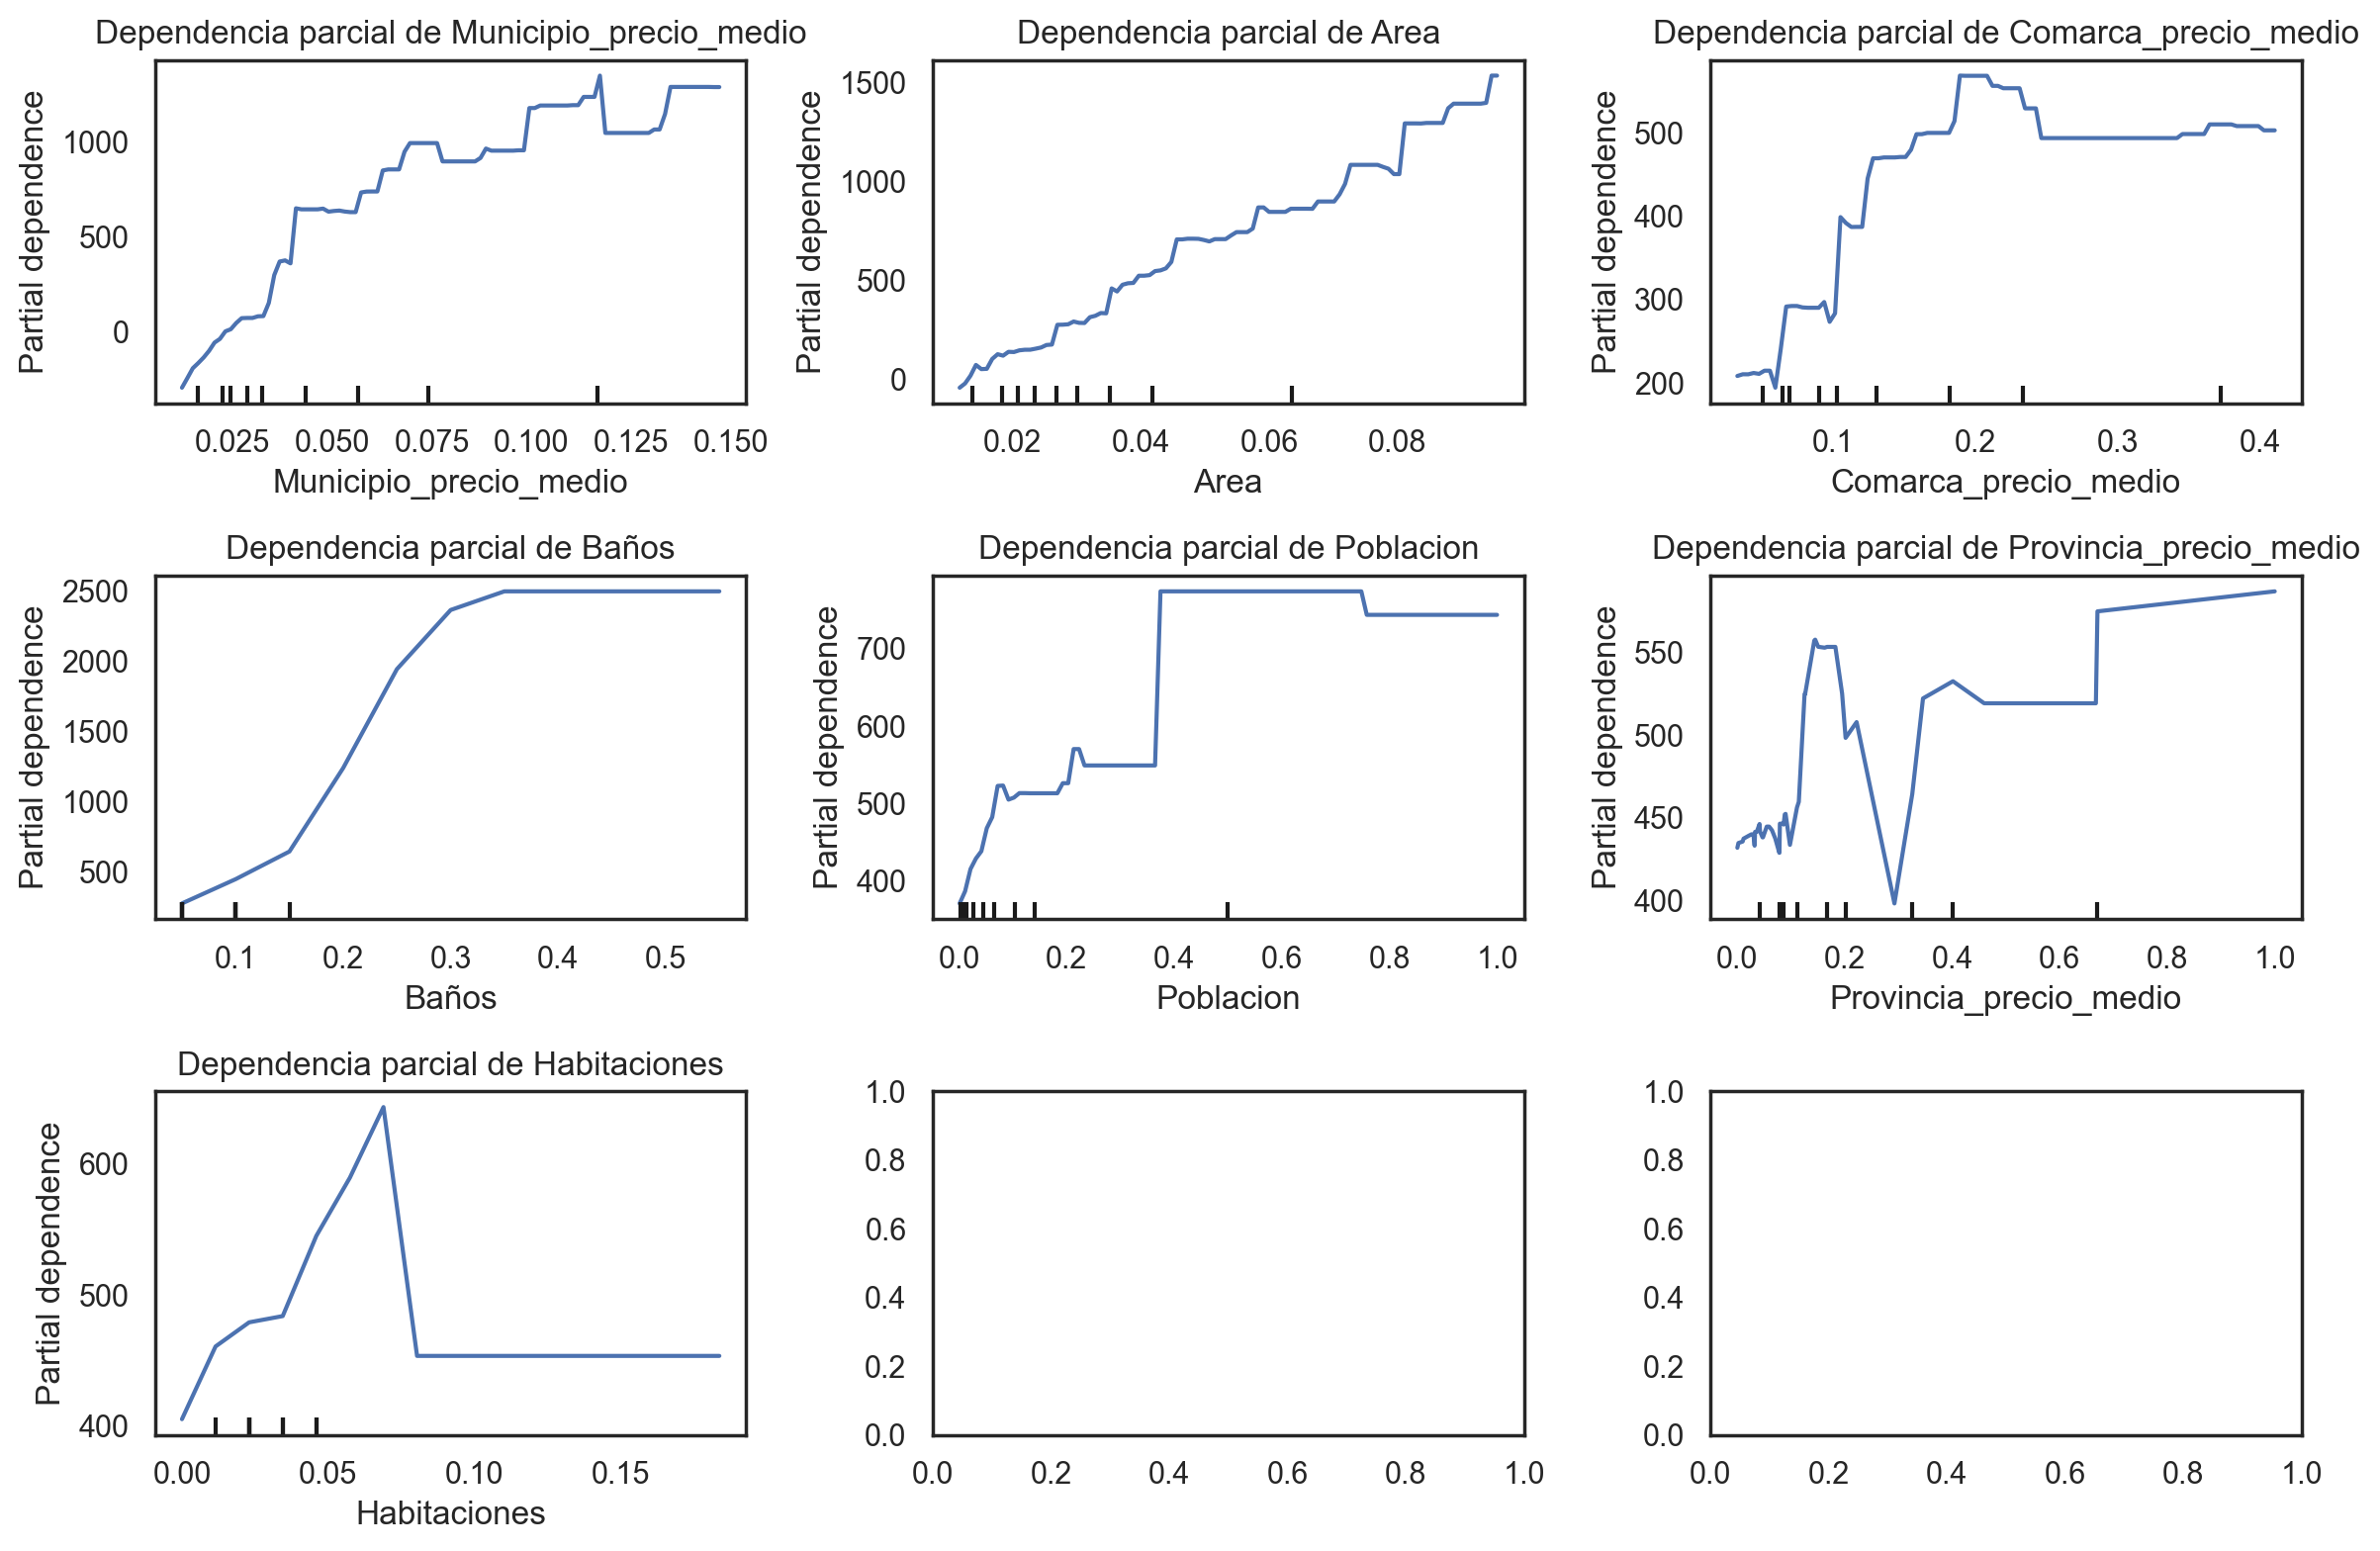

In [236]:
# Partial Dependence plot (PDP)

fig, axs = plt.subplots(3, 3, figsize=(12, 8), dpi = 200)
for i, feature in enumerate(var_importantes):
    row = i // 3
    col = i % 3
    PartialDependenceDisplay.from_estimator(
        GB_regressor, X_test, [feature],
        grid_resolution=100,
        ax=axs[row, col]
    )
    axs[row, col].set_title(f"Dependencia parcial de {feature}")
    axs[row, col].set_xlabel(feature)

plt.tight_layout()
plt.show()